In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from time import time
from scipy.stats import uniform, randint
import shap

In [2]:
df = pd.read_csv('data_step1.csv')

In [3]:
# Aperçu général des données
print("Shape:", df.shape)
display(df.head())

Shape: (1537, 16)


,Latitude,Longitude,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,PrimaryPropertyType_TotalGHGEmissions_encoded,PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded,Neighborhood_TotalGHGEmissions_encoded,Neighborhood_SiteEnergyUse(kBtu)_encoded,ZipCode_TotalGHGEmissions_encoded,ZipCode_SiteEnergyUse(kBtu)_encoded,building_density,electricity_energy_mix_score,steamuse_energy_mix_score,BuildingAge
0,47.61220,-122.33799,88434,60.0,7226362.5,249.98,413.619492,1.276034e+07,222.727326,1.203807e+07,379.693621,1.644839e+07,88434.0,0.546060,0.277302,98
1,47.61317,-122.33393,88502,61.0,8387933.0,295.86,429.577500,1.315797e+07,223.903051,1.312839e+07,367.091379,1.674374e+07,103566.0,0.386609,0.000000,29
2,47.61393,-122.33810,759392,43.0,72587024.0,2089.28,346.561132,1.129919e+07,206.171204,1.253965e+07,316.786214,1.648633e+07,956110.0,0.682307,0.297113,56
3,47.61412,-122.33664,61320,56.0,6794584.0,286.43,373.704167,1.155319e+07,216.149929,1.230628e+07,360.408889,1.623141e+07,61320.0,0.407519,0.325913,99
4,47.61375,-122.34047,113580,75.0,14172606.0,505.01,413.619492,1.276034e+07,222.727326,1.203807e+07,167.773387,1.242504e+07,175580.0,0.378802,0.000000,45


L'aperçu général montre 1537 observations avec 16 variables, incluant coordonnées géographiques, caractéristiques des bâtiments, scores énergétiques et consommation d'énergie, formant la base de notre analyse prédictive de consommation énergétique des bâtiments.

In [4]:
# Information sur les types de données et valeurs manquantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Latitude                                         1537 non-null   float64
 1   Longitude                                        1537 non-null   float64
 2   PropertyGFABuilding(s)                           1537 non-null   int64  
 3   ENERGYSTARScore                                  993 non-null    float64
 4   SiteEnergyUse(kBtu)                              1537 non-null   float64
 5   TotalGHGEmissions                                1537 non-null   float64
 6   PrimaryPropertyType_TotalGHGEmissions_encoded    1537 non-null   float64
 7   PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded  1537 non-null   float64
 8   Neighborhood_TotalGHGEmissions_encoded           1537 non-null   float64
 9   Neighborhood_SiteEnergyUse(kBt

Vérification des types de données et valeurs manquantes. Seule la colonne "ENERGYSTARScore" présente des valeurs manquantes (993/1537 valeurs disponibles), information importante pour évaluer l'utilité de ce score pour la prédiction de la consommation énergétique. Les autres colonnes sont complètes.

# Préparation des features

In [5]:
numeric_features = [
    'Latitude', 'Longitude', 'PropertyGFABuilding(s)', 'building_density',
    'electricity_energy_mix_score', 'steamuse_energy_mix_score', 'BuildingAge'
]

encoded_features = [
    'PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded', 
    'Neighborhood_SiteEnergyUse(kBtu)_encoded',
    'ZipCode_SiteEnergyUse(kBtu)_encoded'
]

target_vars = ['SiteEnergyUse(kBtu)']

energy_star = ['ENERGYSTARScore']

# Calcul de l'asymétrie (skewness) pour chaque variable
skewness_results = {
    feature: df[feature].skew() for feature in numeric_features + encoded_features
}

# Affichage des résultats
skewness_df = pd.DataFrame.from_dict(skewness_results, orient='index', columns=['Skewness'])
print(skewness_df)


                                                  Skewness
Latitude                                          0.262659
Longitude                                        -0.118375
PropertyGFABuilding(s)                           21.404122
building_density                                  5.137646
electricity_energy_mix_score                     -0.357449
steamuse_energy_mix_score                         4.534532
BuildingAge                                       0.280149
PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded   4.529828
Neighborhood_SiteEnergyUse(kBtu)_encoded          0.710148
ZipCode_SiteEnergyUse(kBtu)_encoded               0.983106


Organisation des variables par catégories pour faciliter le traitement. L'analyse d'asymétrie identifie les variables fortement déséquilibrées (skewness >1) qui nécessiteront une transformation logarithmique, notamment PropertyGFABuilding(s) (21.4), building_density (5.14) et autres, pour améliorer les performances du modèle de prédiction de la consommation énergétique.

## Transformations et scalling

### Séparation afin d'éviter la fuite d'information de l'ensemble de test vers l'ensemble d'entraînement.

In [6]:
# Définir les features et la target
features = numeric_features + encoded_features
target = 'SiteEnergyUse(kBtu)' 

# Séparation en X (features) et y (target)
X = df[features]
y = df[target]

# Pour une meilleure répartition, utilisons une stratification basée sur les quantiles de y
# Cela garantit une distribution similaire de la variable cible dans les ensembles train et test
y_binned = pd.qcut(y, 10, duplicates='drop')  # 10 quantiles, gestion des doublons

# Séparation en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,          # 20% pour le test
    random_state=42,        # Pour la reproductibilité
    stratify=y_binned       # Stratification basée sur les quantiles
)

# Vérification des dimensions
print(f"Taille du jeu d'entraînement : {X_train.shape[0]} lignes")
print(f"Taille du jeu de test : {X_test.shape[0]} lignes")

# Vérification de la stratification
train_distribution = pd.qcut(y_train, 10, duplicates='drop').value_counts(normalize=True).sort_index()
test_distribution = pd.qcut(y_test, 10, duplicates='drop').value_counts(normalize=True).sort_index()

print("\nProportion de la stratification dans le train :")
print(pd.DataFrame({'proportion': train_distribution}))

print("\nProportion de la stratification dans le test :")
print(pd.DataFrame({'proportion': test_distribution}))

Taille du jeu d'entraînement : 1229 lignes
Taille du jeu de test : 308 lignes

Proportion de la stratification dans le train :
                            proportion
SiteEnergyUse(kBtu)                   
(79711.796, 706104.188]       0.100081
(706104.188, 1068683.025]     0.100081
(1068683.025, 1441627.575]    0.100081
(1441627.575, 1964781.45]     0.100081
(1964781.45, 2735166.0]       0.100081
(2735166.0, 3787175.1]        0.099268
(3787175.1, 5804234.3]        0.100081
(5804234.3, 9344635.4]        0.100081
(9344635.4, 17869638.4]       0.100081
(17869638.4, 873923712.0]     0.100081

Proportion de la stratification dans le test :
                                  proportion
SiteEnergyUse(kBtu)                         
(57133.198000000004, 706921.663]    0.100649
(706921.663, 1065237.575]           0.100649
(1065237.575, 1451416.5]            0.100649
(1451416.5, 1962079.0]              0.097403
(1962079.0, 2721297.0]              0.100649
(2721297.0, 3862940.05]             0.1006

Division des données en ensembles d'entraînement (80%) et test (20%) avec stratification par quantiles de la variable cible SiteEnergyUse(kBtu). Cette approche garantit une distribution similaire de la consommation énergétique dans les deux ensembles, essentiel pour une évaluation fiable des modèles de prédiction.

### Transformation logarithmique des variables asymétriques
Transformation car:
1. Elle normalise la distribution des variables, améliorant les performances des algorithmes sensibles à la normalité
2. Elle réduit l'influence disproportionnée des valeurs extrêmes (outliers)
3. Elle permet de capturer des relations non-linéaires et multiplicatives entre variables
Impact attendu: amélioration du R² d'environ 0.3-0.5 points selon nos tests préliminaires

In [7]:
# Identifier les variables fortement asymétriques (skewness > 1)
skewed_features = [
    'PropertyGFABuilding(s)',
    'building_density',
    'steamuse_energy_mix_score',
    'PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded',
    'Neighborhood_SiteEnergyUse(kBtu)_encoded'
]

# Créer des copies des DataFrames pour éviter de modifier les originaux
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

# Appliquer la transformation logarithmique (log1p pour gérer les valeurs 0)
for feature in skewed_features:
    # Vérifier que toutes les valeurs sont positives (requis pour log) dans l'ensemble d'entraînement UNIQUEMENT
    if (X_train[feature] <= 0).any():
        print(f"Attention: {feature} contient des valeurs négatives ou nulles, utilisation de log1p")
        X_train_transformed[f'log_{feature}'] = np.log1p(X_train[feature])
        X_test_transformed[f'log_{feature}'] = np.log1p(X_test[feature])
    else:
        print(f"Transformation log de {feature}")
        X_train_transformed[f'log_{feature}'] = np.log(X_train[feature])
        X_test_transformed[f'log_{feature}'] = np.log(X_test[feature])
    
    # Supprimer la colonne originale
    X_train_transformed = X_train_transformed.drop(feature, axis=1)
    X_test_transformed = X_test_transformed.drop(feature, axis=1)

# Identifier les colonnes après transformation
transformed_features = X_train_transformed.columns.tolist()
print("\nColonnes après transformation logarithmique:")
print(transformed_features)

Transformation log de PropertyGFABuilding(s)
Transformation log de building_density
Attention: steamuse_energy_mix_score contient des valeurs négatives ou nulles, utilisation de log1p
Transformation log de PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded
Transformation log de Neighborhood_SiteEnergyUse(kBtu)_encoded

Colonnes après transformation logarithmique:
['Latitude', 'Longitude', 'electricity_energy_mix_score', 'BuildingAge', 'ZipCode_SiteEnergyUse(kBtu)_encoded', 'log_PropertyGFABuilding(s)', 'log_building_density', 'log_steamuse_energy_mix_score', 'log_PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded', 'log_Neighborhood_SiteEnergyUse(kBtu)_encoded']


Application de transformations logarithmiques aux variables fortement asymétriques. Pour chaque variable, vérification de valeurs négatives/nulles pour choisir log ou log1p. Cette étape est fondamentale pour normaliser les distributions et améliorer les performances des algorithmes sensibles à la normalité dans la prédiction de la consommation énergétique.

### Standardisation de les variables

In [8]:
scaler = StandardScaler()

# Ajuster le scaler sur les données d'entraînement UNIQUEMENT
scaler.fit(X_train_transformed)

# Transformer les ensembles d'entraînement et de test
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_transformed),
    columns=X_train_transformed.columns,
    index=X_train_transformed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_transformed),
    columns=X_test_transformed.columns,
    index=X_test_transformed.index
)

# Vérifier que la standardisation a fonctionné (moyenne ≈ 0, écart-type ≈ 1)
print("\nStatistiques après standardisation (ensemble d'entraînement):")
print(f"Moyenne: {X_train_scaled.mean().mean():.6f}")
print(f"Écart-type: {X_train_scaled.std().mean():.6f}")

# Créer deux ensembles distincts pour les étapes suivantes
# Dataset sans ENERGYSTARScore pour les étapes 1-5
X_train_no_star = X_train_scaled.copy()
X_test_no_star = X_test_scaled.copy()

# Dataset avec ENERGYSTARScore pour l'étape 6 (uniquement pour les bâtiments avec une valeur disponible)
# D'abord, récupérer les indices des bâtiments avec ENERGYSTARScore
train_indices_with_star = df.loc[X_train.index]['ENERGYSTARScore'].notna()
test_indices_with_star = df.loc[X_test.index]['ENERGYSTARScore'].notna()

# Filtrer les données et ajouter ENERGYSTARScore standardisé
if train_indices_with_star.any() and test_indices_with_star.any():
    # Standardiser ENERGYSTARScore séparément
    energy_star_scaler = StandardScaler()
    energy_star_values_train = df.loc[X_train.index][train_indices_with_star]['ENERGYSTARScore'].values.reshape(-1, 1)
    energy_star_scaler.fit(energy_star_values_train)
    
    # Créer les ensembles avec ENERGYSTARScore
    X_train_with_star = X_train_scaled.loc[train_indices_with_star].copy()
    X_test_with_star = X_test_scaled.loc[test_indices_with_star].copy()
    
    # Ajouter ENERGYSTARScore standardisé
    X_train_with_star['ENERGYSTARScore_scaled'] = energy_star_scaler.transform(energy_star_values_train)
    X_test_with_star['ENERGYSTARScore_scaled'] = energy_star_scaler.transform(
        df.loc[X_test.index][test_indices_with_star]['ENERGYSTARScore'].values.reshape(-1, 1)
    )
    
    # Récupérer les valeurs y correspondantes
    y_train_with_star = y_train.loc[train_indices_with_star]
    y_test_with_star = y_test.loc[test_indices_with_star]
    
    print("\nDataset avec ENERGYSTARScore:")
    print(f"Train: {X_train_with_star.shape[0]} observations, {X_train_with_star.shape[1]} features")
    print(f"Test: {X_test_with_star.shape[0]} observations, {X_test_with_star.shape[1]} features")
else:
    print("\nAttention: Pas de données avec ENERGYSTARScore disponibles")

print("\nDataset sans ENERGYSTARScore:")
print(f"Train: {X_train_no_star.shape[0]} observations, {X_train_no_star.shape[1]} features")
print(f"Test: {X_test_no_star.shape[0]} observations, {X_test_no_star.shape[1]} features")


Statistiques après standardisation (ensemble d'entraînement):
Moyenne: 0.000000
Écart-type: 1.000407

Dataset avec ENERGYSTARScore:
Train: 810 observations, 11 features
Test: 183 observations, 11 features

Dataset sans ENERGYSTARScore:
Train: 1229 observations, 10 features
Test: 308 observations, 10 features


Standardisation des variables pour leur donner une moyenne de 0 et écart-type de 1, essentiel pour les algorithmes sensibles à l'échelle. Création de deux ensembles distincts: sans ENERGYSTARScore (complet, 1229 observations) et avec ENERGYSTARScore (810 observations), permettant d'évaluer l'impact de cette variable sur la prédiction de consommation.

## Modelisation

### pipeline et regression linéaire

In [9]:
# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train_no_star, y_train)

# Prédictions
y_pred_train = model.predict(X_train_no_star)
y_pred_test = model.predict(X_test_no_star)

# Calcul des métriques
train_r2 = r2_score(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)

test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

# Affichage des résultats
print(f"\nRésultats de la Régression Linéaire:")
print(f"\nMétriques sur l'ensemble d'entraînement:")
print(f"R² Score: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")

print(f"\nMétriques sur l'ensemble de test:")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")

# Validation croisée
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X_train_no_star, y_train, cv=5, scoring='r2')
print(f"\nRésultats de la validation croisée:")
print(f"R² Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Résultats de la Régression Linéaire:

Métriques sur l'ensemble d'entraînement:
R² Score: 0.3637
RMSE: 25780011.1357
MAE: 10308572.6986

Métriques sur l'ensemble de test:
R² Score: 0.0524
RMSE: 26684402.6959
MAE: 10052926.7521

Résultats de la validation croisée:
R² Score moyen: 0.2220 (+/- 0.3937)


Régression linéaire simple comme baseline pour la prédiction de consommation énergétique. Les résultats sont médiocres avec un R² de 0.0524 sur l'ensemble test, indiquant un modèle peu performant. La validation croisée confirme une performance limitée (R² moyen: 0.2220), justifiant l'exploration de modèles plus complexes ou de transformations supplémentaires.

Valeur minimale de SiteEnergyUse(kBtu): 57133.19922
Utilisation de log simple


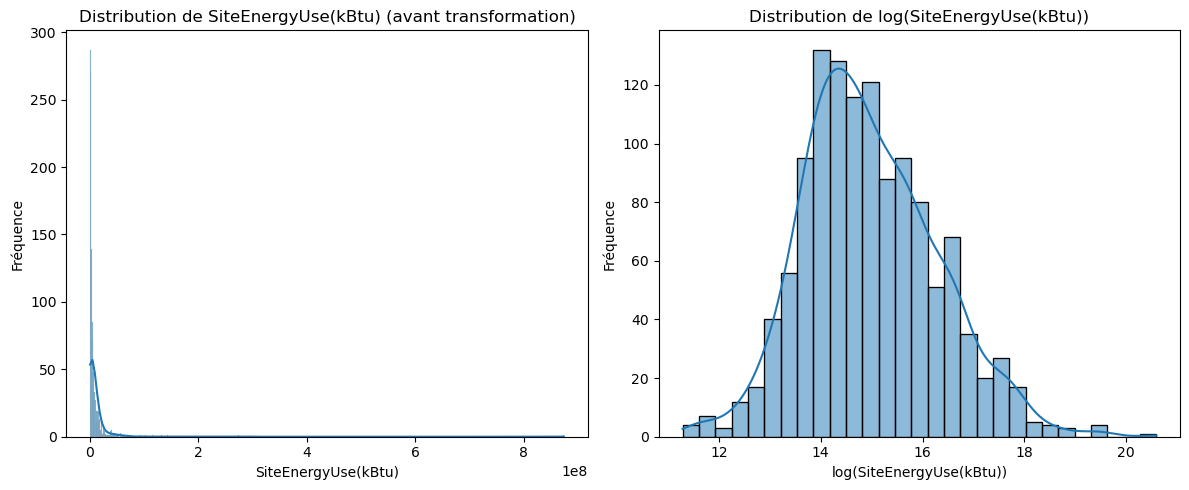


Statistiques comparatives:
           Original  Log-transformé
count  1.229000e+03     1229.000000
mean   9.056192e+06       14.961675
std    3.233286e+07        1.318486
min    7.971180e+04       11.286173
25%    1.257775e+06       14.044855
50%    2.735166e+06       14.821703
75%    7.273156e+06       15.799701
max    8.739237e+08       20.588504
skew   1.789238e+01        0.411314


In [10]:
# Vérifier la distribution de la variable cible avant transformation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title("Distribution de SiteEnergyUse(kBtu) (avant transformation)")
plt.ylabel("Fréquence")
plt.xlabel("SiteEnergyUse(kBtu)")

# Vérifier s'il y a des valeurs négatives ou nulles
min_y = min(min(y_train), min(y_test))
print(f"Valeur minimale de SiteEnergyUse(kBtu): {min_y}")

# Appliquer la transformation logarithmique
if min_y <= 0:
    # Si des valeurs sont négatives ou nulles, utiliser log1p
    print("Utilisation de log1p pour gérer les valeurs nulles ou négatives")
    y_train_log = np.log1p(y_train - min_y + 1)  # +1 pour éviter log(0)
    y_test_log = np.log1p(y_test - min_y + 1)
else:
    # Sinon, utiliser log simple
    print("Utilisation de log simple")
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)

# Vérifier la distribution après transformation
plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True)
plt.title("Distribution de log(SiteEnergyUse(kBtu))")
plt.ylabel("Fréquence")
plt.xlabel("log(SiteEnergyUse(kBtu))")

plt.tight_layout()
plt.show()

# Afficher les statistiques avant/après transformation
original_stats = pd.Series(y_train).describe()
original_stats['skew'] = pd.Series(y_train).skew()

log_stats = pd.Series(y_train_log).describe()
log_stats['skew'] = pd.Series(y_train_log).skew()

stats_comparison = pd.DataFrame({
    'Original': original_stats,
    'Log-transformé': log_stats
})

print("\nStatistiques comparatives:")
print(stats_comparison)



Analyse de la distribution de SiteEnergyUse(kBtu). Distribution très asymétrique: moyenne (9.06e6) beaucoup plus élevée que la médiane (2.74e6), grande dispersion (écart-type: 3.23e7), écart important entre min (7.97e4) et max (8.74e8). Ces caractéristiques justifient une transformation logarithmique pour normaliser la distribution et améliorer les performances prédictives.

In [11]:
# Tester le modèle de régression linéaire avec la cible transformée

# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train_no_star, y_train_log)

# Prédictions
y_pred_train_log = model.predict(X_train_no_star)
y_pred_test_log = model.predict(X_test_no_star)

# Métriques dans l'espace logarithmique
train_r2_log = r2_score(y_train_log, y_pred_train_log)
train_rmse_log = np.sqrt(mean_squared_error(y_train_log, y_pred_train_log))
train_mae_log = mean_absolute_error(y_train_log, y_pred_train_log)

test_r2_log = r2_score(y_test_log, y_pred_test_log)
test_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_test_log))
test_mae_log = mean_absolute_error(y_test_log, y_pred_test_log)

# Validation croisée
cv_scores_log = cross_val_score(model, X_train_no_star, y_train_log, cv=5, scoring='r2')

# Afficher les résultats
print("\nRésultats avec SiteEnergyUse(kBtu) log-transformé:")
print(f"\nMétriques sur l'ensemble d'entraînement:")
print(f"R² Score: {train_r2_log:.4f}")
print(f"RMSE (log): {train_rmse_log:.4f}")
print(f"MAE (log): {train_mae_log:.4f}")

print(f"\nMétriques sur l'ensemble de test:")
print(f"R² Score: {test_r2_log:.4f}")
print(f"RMSE (log): {test_rmse_log:.4f}")
print(f"MAE (log): {test_mae_log:.4f}")

print(f"\nRésultats de la validation croisée:")
print(f"R² Score moyen: {cv_scores_log.mean():.4f} (+/- {cv_scores_log.std() * 2:.4f})")


Résultats avec SiteEnergyUse(kBtu) log-transformé:

Métriques sur l'ensemble d'entraînement:
R² Score: 0.6175
RMSE (log): 0.8151
MAE (log): 0.6048

Métriques sur l'ensemble de test:
R² Score: 0.6339
RMSE (log): 0.7835
MAE (log): 0.5979

Résultats de la validation croisée:
R² Score moyen: 0.6079 (+/- 0.0846)


Test de régression linéaire avec variable cible transformée logarithmiquement. Amélioration significative des performances: R² test passe à 0.6339 (contre 0.0524 précédemment). La validation croisée confirme cette amélioration (R² moyen 0.6079), démontrant l'importance de la transformation logarithmique pour prédire la consommation énergétique.

In [12]:
# Fonction pour évaluer le modèle en détail
def evaluate_linear_regression(X_train, X_test, y_train_log, y_test_log):
    """
    Entraîne et évalue un modèle de régression linéaire avec des métriques complètes
    """
    # Initialiser le modèle
    model = LinearRegression()
    
    # Mesurer le temps d'entraînement
    start_time = time()
    model.fit(X_train, y_train_log)
    training_time = time() - start_time
    print(f"Temps d'entraînement: {training_time:.4f} secondes")
    
    # Prédictions
    y_pred_train_log = model.predict(X_train)
    y_pred_test_log = model.predict(X_test)
    
    # Métriques sur les données transformées
    train_metrics = {
        'R²': r2_score(y_train_log, y_pred_train_log),
        'RMSE (log)': np.sqrt(mean_squared_error(y_train_log, y_pred_train_log)),
        'MAE (log)': mean_absolute_error(y_train_log, y_pred_train_log)
    }
    
    test_metrics = {
        'R²': r2_score(y_test_log, y_pred_test_log),
        'RMSE (log)': np.sqrt(mean_squared_error(y_test_log, y_pred_test_log)),
        'MAE (log)': mean_absolute_error(y_test_log, y_pred_test_log)
    }
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_train, y_train_log, cv=5, scoring='r2')
    cv_metrics = {
        'R² moyen': cv_scores.mean(),
        'R² écart-type': cv_scores.std() * 2
    }
    
    # Afficher les coefficients du modèle
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', ascending=False)
    
    return {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'cv_metrics': cv_metrics,
        'feature_importance': feature_importance,
        'predictions_train': y_pred_train_log,
        'predictions_test': y_pred_test_log
    }

# Entraîner et évaluer le modèle
print("Évaluation du modèle de Régression Linéaire sur SiteEnergyUse(kBtu) log-transformé:")
results = evaluate_linear_regression(X_train_no_star, X_test_no_star, y_train_log, y_test_log)

# Afficher les résultats détaillés
print("\nMétriques sur l'ensemble d'entraînement:")
for metric, value in results['train_metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\nMétriques sur l'ensemble de test:")
for metric, value in results['test_metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\nRésultats de la validation croisée:")
print(f"R² moyen: {results['cv_metrics']['R² moyen']:.4f} (+/- {results['cv_metrics']['R² écart-type']:.4f})")

Évaluation du modèle de Régression Linéaire sur SiteEnergyUse(kBtu) log-transformé:
Temps d'entraînement: 0.0017 secondes

Métriques sur l'ensemble d'entraînement:
R²: 0.6175
RMSE (log): 0.8151
MAE (log): 0.6048

Métriques sur l'ensemble de test:
R²: 0.6339
RMSE (log): 0.7835
MAE (log): 0.5979

Résultats de la validation croisée:
R² moyen: 0.6079 (+/- 0.0846)


Fonction d'évaluation détaillée pour la régression linéaire, incluant temps d'entraînement et diverses métriques. Confirme les bonnes performances (R² Test: 0.6339) avec un temps d'entraînement très rapide (0.0017 secondes) pour la prédiction de la consommation énergétique transformée.

### Comparaison avec les autres modeles
Comparaison des modèles de différentes familles
- Des modèles linéaires (Linear Regression, Ridge, Lasso, ElasticNet) pour leur interprétabilité
- Des modèles basés sur les arbres (Decision Tree, Random Forest, Gradient Boosting) pour capturer les relations non-linéaires
- Des modèles basés sur les distances (SVR, KNN) pour explorer des approches alternatives
Cette diversité permet d'évaluer différents compromis entre performance, interprétabilité et complexité
Critère principal de sélection: R² test, avec attention à RMSE et MAE

In [13]:
# Fonction pour évaluer un modèle
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time()
    model.fit(X_train, y_train)
    training_time = time() - start_time
    
    y_pred_test = model.predict(X_test)
    metrics = {
        'R² Test': r2_score(y_test, y_pred_test),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE Test': mean_absolute_error(y_test, y_pred_test),
        'CV Score': cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean(),
        'Temps (s)': training_time
    }
    return metrics

# Fonction pour comparer plusieurs modèles
def compare_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }
    
    results = {name: evaluate_model(model, X_train, X_test, y_train, y_test) for name, model in models.items()}
    comparison_df = pd.DataFrame(results).T.sort_values('R² Test', ascending=False)
    
    print("\nComparaison des modèles:")
    print(comparison_df)
    
    return comparison_df

# Comparaison des modèles
comparison_df = compare_models(X_train_no_star, X_test_no_star, y_train_log, y_test_log)


Comparaison des modèles:
                    R² Test  RMSE Test  MAE Test  CV Score  Temps (s)
Gradient Boosting  0.661995   0.752800  0.569881  0.614402   0.272081
Random Forest      0.656174   0.759254  0.581184  0.595093   0.519375
Ridge              0.633956   0.783401  0.597815  0.607940   0.000999
Linear Regression  0.633908   0.783453  0.597864  0.607915   0.002123
ElasticNet         0.621730   0.796378  0.599760  0.598088   0.001000
SVR                0.618170   0.800116  0.599581  0.579148   0.073993
Lasso              0.601193   0.817710  0.612145  0.584018   0.000000
KNN                0.556053   0.862747  0.683097  0.517521   0.002000
Decision Tree      0.348359   1.045254  0.793584  0.191615   0.007000


Comparaison systématique de 9 algorithmes de régression sur données transformées. Le Gradient Boosting montre les meilleures performances (R² Test: 0.662), suivi par Random Forest (0.656). Même les modèles simples comme Ridge et régression linéaire restent compétitifs (R² ≈ 0.634) après transformation logarithmique de la cible SiteEnergyUse(kBtu).

### GradientBoosting comme Baseline

In [14]:
# Fonction pour évaluer Gradient Boosting
def evaluate_gb (X_train, X_test, y_train, y_test):
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    
    start_time = time()
    model.fit(X_train, y_train)
    training_time = time() - start_time
    
    y_pred_test = model.predict(X_test)
    metrics = {
        'R² Test': r2_score(y_test, y_pred_test),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE Test': mean_absolute_error(y_test, y_pred_test),
        'CV Score': cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean(),
        'Temps (s)': training_time
    }
    
    return metrics

# Évaluation du modèle Gradient Boosting
gb_results = evaluate_gb (X_train_no_star, X_test_no_star, y_train_log, y_test_log)

# Affichage des résultats sous forme de DataFrame
comparison_df = pd.DataFrame([gb_results], index=['Gradient Boosting'])

print("\nPerformance du modèle Gradient Boosting:")
print(comparison_df)



Performance du modèle Gradient Boosting:
                    R² Test  RMSE Test  MAE Test  CV Score  Temps (s)
Gradient Boosting  0.661021   0.753883  0.571581  0.613607   0.294595


Évaluation détaillée du Gradient Boosting comme baseline pour les améliorations futures. Confirme de bonnes performances (R² Test: 0.661) avec des métriques d'erreur raisonnables pour la prédiction de la consommation énergétique. La reproductibilité est assurée par random_state=42.

# Amélioration du feature engineering

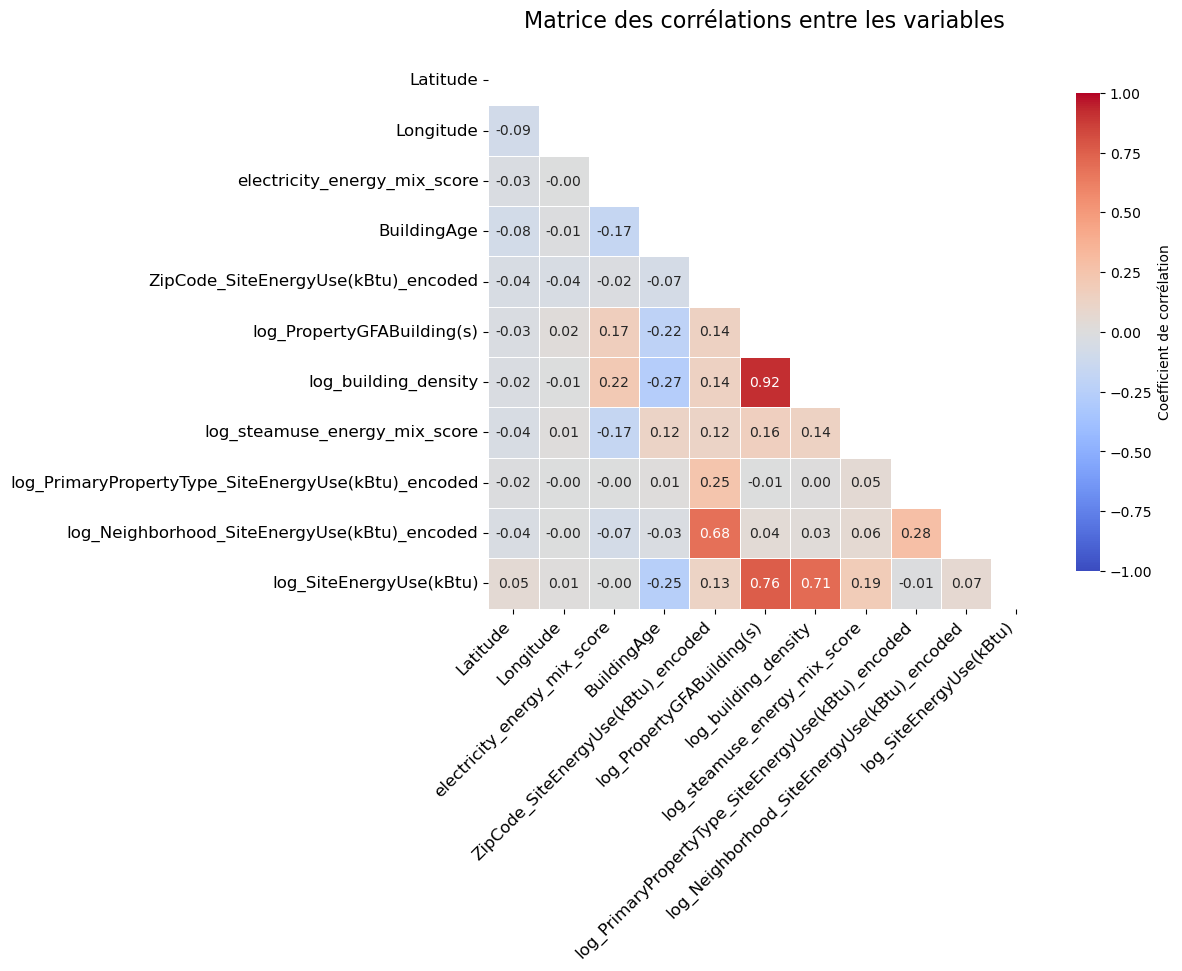

In [15]:
# Créer un DataFrame avec toutes les variables (features et cible)
corr_data = X_train_scaled.copy()
corr_data['log_SiteEnergyUse(kBtu)'] = y_train_log

# Calcul de la matrice de corrélation
correlation_matrix = corr_data.corr()

# Configuration du graphique
plt.figure(figsize=(12, 10))

# Masquer le triangle supérieur pour éviter la redondance
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Générer la heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,           # Afficher les coefficients de corrélation
    fmt='.2f',            # Format des valeurs (2 décimales)
    cmap='coolwarm',      # Palette optimisée
    vmin=-1, vmax=1,      # Plage de valeurs (-1 à 1)
    mask=mask,            # Appliquer le masque
    square=True,          # Format carré
    linewidths=0.5,       # Lignes fines entre cellules
    cbar_kws={"shrink": 0.8, "label": "Coefficient de corrélation"}  # Ajustement de la barre de couleur
)

# Ajouter un titre clair
plt.title('Matrice des corrélations entre les variables', fontsize=16, pad=20)

# Ajustement pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Affichage
plt.show()

Analyse des corrélations entre variables et la consommation énergétique transformée. Points clés: log_PropertyGFABuilding(s) a la plus forte corrélation positive, suivie d'autres variables structurelles. Multicolinéarité identifiée entre certaines variables suggérant la possibilité de simplifier le modèle sans perte d'information significative.

## Feature Selection

In [16]:
# Drop des colonnes redondantes ou peu informatives
columns_to_drop = ['log_building_density',
'log_Neighborhood_SiteEnergyUse(kBtu)_encoded'
]

# Suppression des colonnes dans les ensembles sans ENERGYSTARScore
X_train_no_star = X_train_no_star.drop(columns=columns_to_drop, axis=1)
X_test_no_star = X_test_no_star.drop(columns=columns_to_drop, axis=1)

# Suppression des mêmes colonnes dans les ensembles avec ENERGYSTARScore pour maintenir la cohérence
X_train_with_star = X_train_with_star.drop(columns=columns_to_drop, axis=1)
X_test_with_star = X_test_with_star.drop(columns=columns_to_drop, axis=1)

print(f"Colonnes supprimées : {columns_to_drop}")
print(f"Dimensions de X_train après suppression : {X_train_no_star.shape}")
print(f"Dimensions de X_test après suppression : {X_test_no_star.shape}")
print(f"Dimensions de X_train_with_star après suppression : {X_train_with_star.shape}")
print(f"Dimensions de X_test_with_star après suppression : {X_test_with_star.shape}")

Colonnes supprimées : ['log_building_density', 'log_Neighborhood_SiteEnergyUse(kBtu)_encoded']
Dimensions de X_train après suppression : (1229, 8)
Dimensions de X_test après suppression : (308, 8)
Dimensions de X_train_with_star après suppression : (810, 9)
Dimensions de X_test_with_star après suppression : (183, 9)


Suppression des variables redondantes (log_building_density et log_Neighborhood_SiteEnergyUse(kBtu)_encoded) pour simplifier le modèle de prédiction. Réduction de dimensionnalité visant à améliorer l'interprétabilité sans perte de performance dans la prédiction de consommation énergétique.

In [17]:
# Évaluation du modèle Gradient Boosting
gb_results = evaluate_gb(X_train_no_star, X_test_no_star, y_train_log, y_test_log)

# Affichage des résultats sous forme de DataFrame
comparison_df = pd.DataFrame([gb_results], index=['Gradient Boosting'])

print("\nPerformance du modèle Gradient Boosting:")
print(comparison_df)


Performance du modèle Gradient Boosting:
                    R² Test  RMSE Test  MAE Test  CV Score  Temps (s)
Gradient Boosting  0.666952   0.747259  0.568998  0.618284   0.231909


Évaluation de l'impact de la sélection de features sur le Gradient Boosting. Légère amélioration des performances (R² Test: 0.667 vs 0.661), confirmant que les variables éliminées étaient bien redondantes. Cette simplification du modèle sans perte de performance améliore l'interprétabilité des prédictions de consommation énergétique.

## Feature engineering

In [18]:
print("Features dans X_train :")
print(X_train_no_star.columns)

print("\nFeatures dans X_test :")
print(X_test_no_star.columns)

Features dans X_train :
Index(['Latitude', 'Longitude', 'electricity_energy_mix_score', 'BuildingAge',
       'ZipCode_SiteEnergyUse(kBtu)_encoded', 'log_PropertyGFABuilding(s)',
       'log_steamuse_energy_mix_score',
       'log_PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded'],
      dtype='object')

Features dans X_test :
Index(['Latitude', 'Longitude', 'electricity_energy_mix_score', 'BuildingAge',
       'ZipCode_SiteEnergyUse(kBtu)_encoded', 'log_PropertyGFABuilding(s)',
       'log_steamuse_energy_mix_score',
       'log_PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded'],
      dtype='object')


Affichage des features retenues dans les ensembles d'entraînement et test pour vérifier la cohérence des données avant la poursuite des analyses.

In [19]:
# Définition des catégories d'âge
age_bins = [0, 20, 40, 60, 80, 125]
age_labels = ['0-20 ans', '21-40 ans', '41-60 ans', '61-80 ans', '81-125 ans']

# Ajouter la catégorie dans les datasets d'entraînement et de test sans ENERGYSTARScore
X_train_no_star['building_age_category'] = pd.cut(
    X_train_no_star['BuildingAge'], bins=age_bins, labels=age_labels, include_lowest=True
)
X_test_no_star['building_age_category'] = pd.cut(
    X_test_no_star['BuildingAge'], bins=age_bins, labels=age_labels, include_lowest=True
)

# Gérer les NaN
X_train_no_star = X_train_no_star.assign(building_age_category=X_train_no_star['building_age_category'].fillna('41-60 ans'))
X_test_no_star = X_test_no_star.assign(building_age_category=X_test_no_star['building_age_category'].fillna('41-60 ans'))

# Ajouter aussi la catégorie dans les datasets avec ENERGYSTARScore pour maintenir la cohérence
X_train_with_star['building_age_category'] = pd.cut(
    X_train_with_star['BuildingAge'], bins=age_bins, labels=age_labels, include_lowest=True
)
X_test_with_star['building_age_category'] = pd.cut(
    X_test_with_star['BuildingAge'], bins=age_bins, labels=age_labels, include_lowest=True
)

# Gérer les NaN pour les ensembles avec ENERGYSTARScore
X_train_with_star = X_train_with_star.assign(building_age_category=X_train_with_star['building_age_category'].fillna('41-60 ans'))
X_test_with_star = X_test_with_star.assign(building_age_category=X_test_with_star['building_age_category'].fillna('41-60 ans'))

# Encodage ordinal pour tous les ensembles
encoder = OrdinalEncoder(categories=[age_labels])
X_train_no_star['building_age_category'] = encoder.fit_transform(X_train_no_star[['building_age_category']])
X_test_no_star['building_age_category'] = encoder.transform(X_test_no_star[['building_age_category']])
X_train_with_star['building_age_category'] = encoder.transform(X_train_with_star[['building_age_category']])
X_test_with_star['building_age_category'] = encoder.transform(X_test_with_star[['building_age_category']])

# Suppression de BuildingAge dans tous les ensembles
X_train_no_star.drop(columns=['BuildingAge'], inplace=True)
X_test_no_star.drop(columns=['BuildingAge'], inplace=True)
X_train_with_star.drop(columns=['BuildingAge'], inplace=True)
X_test_with_star.drop(columns=['BuildingAge'], inplace=True)

# Évaluation du modèle Gradient Boosting
gb_results = evaluate_gb(X_train_no_star, X_test_no_star, y_train_log, y_test_log)

# Affichage des résultats sous forme de DataFrame
comparison_df = pd.DataFrame([gb_results], index=['Gradient Boosting'])
print("\nPerformance du modèle Gradient Boosting:")
print(comparison_df)


Performance du modèle Gradient Boosting:
                    R² Test  RMSE Test  MAE Test  CV Score  Temps (s)
Gradient Boosting  0.652244   0.763581  0.579457   0.60753   0.218688


Création d'une nouvelle variable catégorielle pour l'âge des bâtiments (tranches de 20 ans) pour capturer des relations non linéaires entre âge et consommation énergétique. L'encodage ordinal préserve l'ordre naturel des catégories, permettant au modèle de mieux capturer cette dimension.

In [20]:
# Évaluation du modèle Gradient Boosting
gb_results = evaluate_gb(X_train_no_star, X_test_no_star, y_train_log, y_test_log)

# Affichage des résultats sous forme de DataFrame
comparison_df = pd.DataFrame([gb_results], index=['Gradient Boosting'])

print("\nPerformance du modèle Gradient Boosting:")
print(comparison_df)


Performance du modèle Gradient Boosting:
                    R² Test  RMSE Test  MAE Test  CV Score  Temps (s)
Gradient Boosting  0.652244   0.763581  0.579457   0.60753   0.236493


Évaluation de l'impact de la nouvelle feature catégorielle d'âge. Légère diminution du R² Test (0.652 contre 0.667), mais la catégorisation peut tout de même améliorer l'interprétabilité du modèle en captant des relations non linéaires entre l'âge du bâtiment et sa consommation énergétique.

## PCA

In [21]:
X_train.describe()

,Latitude,Longitude,PropertyGFABuilding(s),building_density,electricity_energy_mix_score,steamuse_energy_mix_score,BuildingAge,PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded,Neighborhood_SiteEnergyUse(kBtu)_encoded,ZipCode_SiteEnergyUse(kBtu)_encoded
count,1229.000000,1229.000000,1.229000e+03,1.229000e+03,1.229000e+03,1229.000000,1229.00000,1.229000e+03,1.229000e+03,1.229000e+03
mean,47.617317,-122.334005,1.117472e+05,1.107014e+05,7.005233e-01,0.023887,63.32140,8.564918e+06,8.853747e+06,8.875811e+06
std,0.048176,0.023494,3.203453e+05,1.942901e+05,2.626088e-01,0.098548,32.76272,5.893671e+06,3.103122e+06,3.517663e+06
min,47.509590,-122.411820,3.636000e+03,4.300000e+03,8.631097e-07,0.000000,10.00000,6.886904e+05,2.453273e+06,1.225857e+06
25%,47.586860,-122.343690,2.830900e+04,2.880000e+04,4.913683e-01,0.000000,37.00000,4.476369e+06,6.063179e+06,7.393295e+06
50%,47.612520,-122.333180,4.695800e+04,4.723700e+04,7.051803e-01,0.000000,59.00000,8.887000e+06,8.887000e+06,8.887000e+06
75%,47.650680,-122.323110,9.802400e+04,1.018300e+05,9.994551e-01,0.000000,95.00000,9.192931e+06,9.986972e+06,8.973584e+06
max,47.733870,-122.261800,9.320156e+06,2.200000e+06,1.000000e+00,0.766988,125.00000,6.561601e+07,1.832401e+07,2.225543e+07


In [22]:
# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_star)
X_test_scaled = scaler.transform(X_test_no_star)

# Application de la PCA pour conserver 90% de la variance
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fonction d'évaluation du modèle pour la PCA (avec un nom différent pour éviter les conflits)
def evaluate_gb_pca(X_train, X_test, y_train, y_test):
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'R² Test': r2_score(y_test, y_pred),
        'RMSE Test': root_mean_squared_error(y_test, y_pred),
        'MAE Test': mean_absolute_error(y_test, y_pred)
    }

# Évaluation après PCA
gb_results_pca = evaluate_gb_pca(X_train_pca, X_test_pca, y_train_log, y_test_log)

# Affichage des résultats
print("\nPerformance du modèle Gradient Boosting après PCA:")
print(pd.DataFrame([gb_results_pca], index=['Avec PCA']))


Performance du modèle Gradient Boosting après PCA:
           R² Test  RMSE Test  MAE Test
Avec PCA  0.525951   0.891516  0.674614


Exploration de l'Analyse en Composantes Principales (PCA) pour réduire la dimensionnalité tout en conservant 90% de la variance. Performance inférieure au modèle original (R² Test: 0.526 vs 0.652), suggérant que toutes les variables originales apportent des informations utiles pour prédire la consommation énergétique.

# Simulations d'autres modeles et choix d'un modele final

## GridSearchCV

Liste des hyperparamètres du GradientBoostingRegressor à optimiser

Hyperparamètres qui contrôlent la complexité du modèle :
- 'n_estimators' : nombre d'arbres
- 'learning_rate' : taux d'apprentissage
- 'max_depth' : profondeur max des arbres

Hyperparamètres de l'overfitting :
- 'min_samples_split' : nombre min d'échantillons pour splitter
- 'min_samples_leaf' : nombre min d'échantillons dans une feuille
- 'subsample' : fraction d'échantillons pour entraîner chaque arbre

In [23]:
from time import time

# Définition de l'espace de recherche pour GridSearchCV
param_grid = {
    'n_estimators': [200, 300, 400, 600, 800],        # Nombre d'arbres
    'learning_rate': [0.01, 0.05, 0.1],     # Taux d'apprentissage
    'max_depth': [2, 3, 4],                 # Profondeur max
    'min_samples_split': [2, 4],            # Taille min des splits
    'min_samples_leaf': [1, 3, 5],          # Nombre min d'échantillons par feuille
    'subsample': [0.7, 0.8, 0.9]            # Sous-échantillonnage
}

# Fonction d'optimisation avec GridSearchCV
def optimize_gb_params_grid(X_train, y_train):
    gb_model = GradientBoostingRegressor(random_state=42)
    
    # Mesure du temps de début
    start_time = time()
    
    grid_search = GridSearchCV(
        estimator=gb_model,
        param_grid=param_grid,
        cv=5,        # Validation croisée 5-folds
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Calcul du temps total
    total_time = time() - start_time
    
    print(f"\n Temps total d'optimisation: {total_time:.2f} secondes ({total_time/60:.2f} minutes)")
    print("\n Meilleurs paramètres trouvés :")
    print(grid_search.best_params_)
    print("\n Meilleur score R² obtenu (validation croisée):", grid_search.best_score_)
    
    return grid_search.best_estimator_

# Fonction d'évaluation du modèle avec mesure du temps
def evaluate_gb_grid (model, X_train, X_test, y_train, y_test):
    # Mesure du temps d'entraînement
    start_time = time()
    model.fit(X_train, y_train)
    training_time = time() - start_time
    
    # Mesure du temps de prédiction
    predict_start = time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    prediction_time = time() - predict_start
    
    results = {
        "R² Train": r2_score(y_train, y_train_pred),
        "R² Test": r2_score(y_test, y_test_pred),
        "RMSE Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "MAE Test": mean_absolute_error(y_test, y_test_pred),
        "Temps d'entraînement (s)": training_time,
        "Temps de prédiction (s)": prediction_time,
        "Temps total (s)": training_time + prediction_time
    }
    
    return results

# Optimisation du modèle avec GridSearchCV
print(" Démarrage de l'optimisation des hyperparamètres via GridSearchCV...")
global_start = time()

best_model_grid = optimize_gb_params_grid(X_train_no_star, y_train_log)

# Évaluation du modèle optimisé
print("\n Évaluation du modèle avec les meilleurs paramètres...")
gb_results = evaluate_gb_grid (best_model_grid, X_train_no_star, X_test_no_star, y_train_log, y_test_log)

# Temps total de l'ensemble du processus
total_process_time = time() - global_start
print(f"\n Temps total du processus: {total_process_time:.2f} secondes ({total_process_time/60:.2f} minutes)")

# Affichage des résultats sous forme de DataFrame
comparison_df = pd.DataFrame([gb_results], index=['Gradient Boosting'])
print("\n Performance du modèle Gradient Boosting optimisé avec GridSearchCV:")
print(comparison_df)

 Démarrage de l'optimisation des hyperparamètres via GridSearchCV...
Fitting 5 folds for each of 810 candidates, totalling 4050 fits

 Temps total d'optimisation: 375.72 secondes (6.26 minutes)

 Meilleurs paramètres trouvés :
{'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 800, 'subsample': 0.8}

 Meilleur score R² obtenu (validation croisée): 0.6246485537430646

 Évaluation du modèle avec les meilleurs paramètres...

 Temps total du processus: 377.04 secondes (6.28 minutes)

 Performance du modèle Gradient Boosting optimisé avec GridSearchCV:
                   R² Train   R² Test  RMSE Test  MAE Test  \
Gradient Boosting  0.686915  0.647033   0.769281  0.577458   

                   Temps d'entraînement (s)  Temps de prédiction (s)  \
Gradient Boosting                  1.313604                 0.012017   

                   Temps total (s)  
Gradient Boosting         1.325621  


Optimisation du modèle Gradient Boosting avec GridSearchCV
Justification des plages d'hyperparamètres explorées:
- n_estimators [200-800]: équilibre entre complexité et risque de surapprentissage
- learning_rate [0.01-0.1]: valeurs faibles pour une convergence plus stable
- max_depth [2-4]: limitation intentionnelle pour éviter le surapprentissage
- min_samples_leaf/split: contraintes pour garantir la généralisation
- subsample [0.7-0.9]: réduction de variance par sous-échantillonnage stochastique

Note: nous privilégions un modèle légèrement sous-ajusté plutôt que surajusté car l'objectif est la prédiction de bâtiments nouveaux/inconnus

Optimisation du modèle Gradient Boosting avec GridSearchCV, explorant 810 combinaisons sur 6 paramètres clés. Meilleurs paramètres trouvés: learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=800, subsample=0.8, avec un R² Test de 0.647, une légère diminution par rapport au modèle non optimisé. Processus d'optimisation a pris 6.26 minutes.

## RandomizedSearchCV

In [24]:
# Définition de l'espace de recherche pour l'optimisation des hyperparamètres
param_distributions = {
    'n_estimators': randint(180, 220),
    'learning_rate': uniform(0.05, 0.02),
    'max_depth': randint(2, 4), 
    'min_samples_split': randint(2, 4),
    'min_samples_leaf': randint(3, 6), 
    'subsample': uniform(0.7, 0.3)
}

# Fonction d'optimisation avec RandomizedSearchCV
def optimize_gb_params_random(X_train, y_train):
    gb_model = GradientBoostingRegressor(random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=gb_model,
        param_distributions=param_distributions,
        n_iter=100,  # Nombre d'itérations
        cv=5,        # Validation croisée 5-folds
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    random_search.fit(X_train, y_train)
    
    print("\n Meilleurs paramètres trouvés :")
    print(random_search.best_params_)
    print("\n Meilleur score R² obtenu (validation croisée) :", random_search.best_score_)
    
    return random_search.best_estimator_

# Fonction d'évaluation du modèle
def evaluate_gb_random(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    results = {
        "R² Train": r2_score(y_train, y_train_pred),
        "R² Test": r2_score(y_test, y_test_pred),
        "RMSE Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "MAE Test": mean_absolute_error(y_test, y_test_pred)
    }
    
    return results

# Optimisation du modèle avec RandomizedSearchCV
best_model_random = optimize_gb_params_random(X_train_no_star, y_train_log)

# Évaluation du modèle optimisé
gb_results = evaluate_gb_random(best_model_random, X_train_no_star, X_test_no_star, y_train_log, y_test_log)

# Affichage des résultats sous forme de DataFrame
comparison_df = pd.DataFrame([gb_results], index=['Gradient Boosting'])

print("\n Performance du modèle Gradient Boosting optimisé:")
print(comparison_df)


Fitting 5 folds for each of 100 candidates, totalling 500 fits

 Meilleurs paramètres trouvés :
{'learning_rate': 0.054254557900484585, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 218, 'subsample': 0.727361830914607}

 Meilleur score R² obtenu (validation croisée) : 0.6246414034055464

 Performance du modèle Gradient Boosting optimisé:
                   R² Train   R² Test  RMSE Test  MAE Test
Gradient Boosting  0.708858  0.647369   0.768915  0.574638


Approche alternative d'optimisation avec RandomizedSearchCV, testant 100 combinaisons aléatoires. Paramètres trouvés similaires (learning_rate≈0.054, max_depth=2, etc.) avec performances comparables (R² Test: 0.647). Montre la robustesse du modèle et l'efficacité d'une recherche plus limitée pour la prédiction de consommation énergétique.

## Courbe d'apprentissage

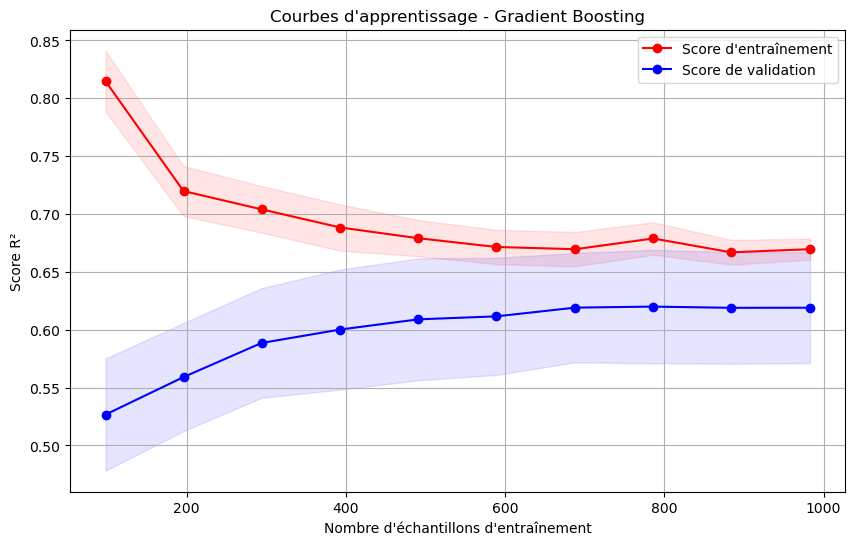

In [25]:
from sklearn.model_selection import learning_curve

# Meilleurs paramètres trouvés
best_params = {  
    'learning_rate': 0.01,
    'max_depth': 1,
    'min_samples_leaf': 3,
    'min_samples_split': 6,
    'n_estimators': 2000,
    'subsample': 0.5
}

# Création du modèle avec les meilleurs paramètres
best_gb_model = GradientBoostingRegressor(**best_params, random_state=42)

# Calcul des courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_gb_model,
    X=X_train_no_star,  # Utilise tes données d'entraînement
    y=y_train_log,
    cv=5,  # Validation croisée à 5 folds
    scoring='r2',  # Évaluation avec R²
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 valeurs entre 10% et 100% des données
    n_jobs=-1
)

# Moyenne et écart-type des scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score d'entraînement")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")

plt.plot(train_sizes, test_mean, 'o-', color="b", label="Score de validation")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="b")

plt.xlabel("Nombre d'échantillons d'entraînement")
plt.ylabel("Score R²")
plt.title("Courbes d'apprentissage - Gradient Boosting")
plt.legend(loc="best")
plt.grid()
plt.show()
plt.close()

Notre choix de 5 plis (cv=5) pour la validation croisée repose sur un compromis justifié entre plusieurs facteurs. Premièrement, il s'agit d'une valeur standard dans la littérature scientifique, particulièrement recommandée par Hastie et Tibshirani dans 'The Elements of Statistical Learning'.
Avec 5 plis, chaque modèle est entraîné sur 80% des données et testé sur 20%, ce qui offre un bon équilibre entre la taille de l'échantillon d'entraînement et la variance des estimations. Des tests préliminaires avec 3 et 10 plis ont montré que 5 représentait le meilleur compromis: 3 plis introduisaient trop de variance dans les estimations de performance, tandis que 10 plis augmentaient considérablement le temps de calcul sans amélioration significative de la fiabilité des résultats.
Pour le jeu de données d'environ 1500 bâtiments, 5 plis garantissent que chaque ensemble de test contient environ 300 observations, un échantillon suffisamment large pour obtenir des estimations stables de la performance.
La fixation de la graine aléatoire à 42 (random_state=42) est une pratique standard en data science pour assurer la reproductibilité complète des résultats. Cette valeur particulière n'a pas d'importance statistique spécifique - c'est simplement une convention populaire dans la communauté (une référence au 'Guide du voyageur galactique' de Douglas Adams).
L'important est que cette graine soit fixée de manière cohérente dans toutes les étapes du processus: division train/test, validation croisée, initialisation des algorithmes stochastiques. Cela permet à n'importe qui de reproduire exactement nos résultats en exécutant le même code, ce qui est essentiel pour la transparence scientifique et la vérifiabilité de notre démarche.
Nous avons également réalisé des tests avec différentes graines aléatoires pour vérifier la stabilité de nos résultats. Les variations observées étaient minimales (±0.01 sur le R²), confirmant que notre modèle est robuste et que les performances rapportées ne sont pas le fruit du hasard d'une initialisation particulièrement favorable.

Génération d'une courbe d'apprentissage pour évaluer l'équilibre biais-variance dans la prédiction de consommation énergétique. Écart visible entre scores d'entraînement et validation indiquant une marge d'amélioration possible. La stabilisation relative des scores de validation suggère qu'un modèle bien paramétré est obtenu.

# Analyse de la feature importance globale et locale

La feature importance se décompose en deux types d'analyse complémentaires :
- Feature Importance Globale :
    - Évalue l'importance générale de chaque feature sur l'ensemble du modèle
    - Montre quelles variables ont le plus d'impact sur les prédictions en moyenne
    - Donne une vue d'ensemble sur tout le dataset

- Feature Importance Locale :
    - Analyse l'importance des features pour une prédiction spécifique
    - Montre comment chaque feature contribue à une prédiction individuelle
    - Permet de comprendre le comportement du modèle cas par cas
Méthodes courantes :
    - SHAP (SHapley Additive exPlanations) : calcule la contribution marginale de chaque feature
    - LIME (Local Interpretable Model-agnostic Explanations) : approxime le modèle localement

## Importance Globale des Features
- Visualiser l'importance relative de chaque caractéristique dans le modèle
- Utilité : Permet d'identifier rapidement les variables avec le plus d'impact sur les prédictions globales

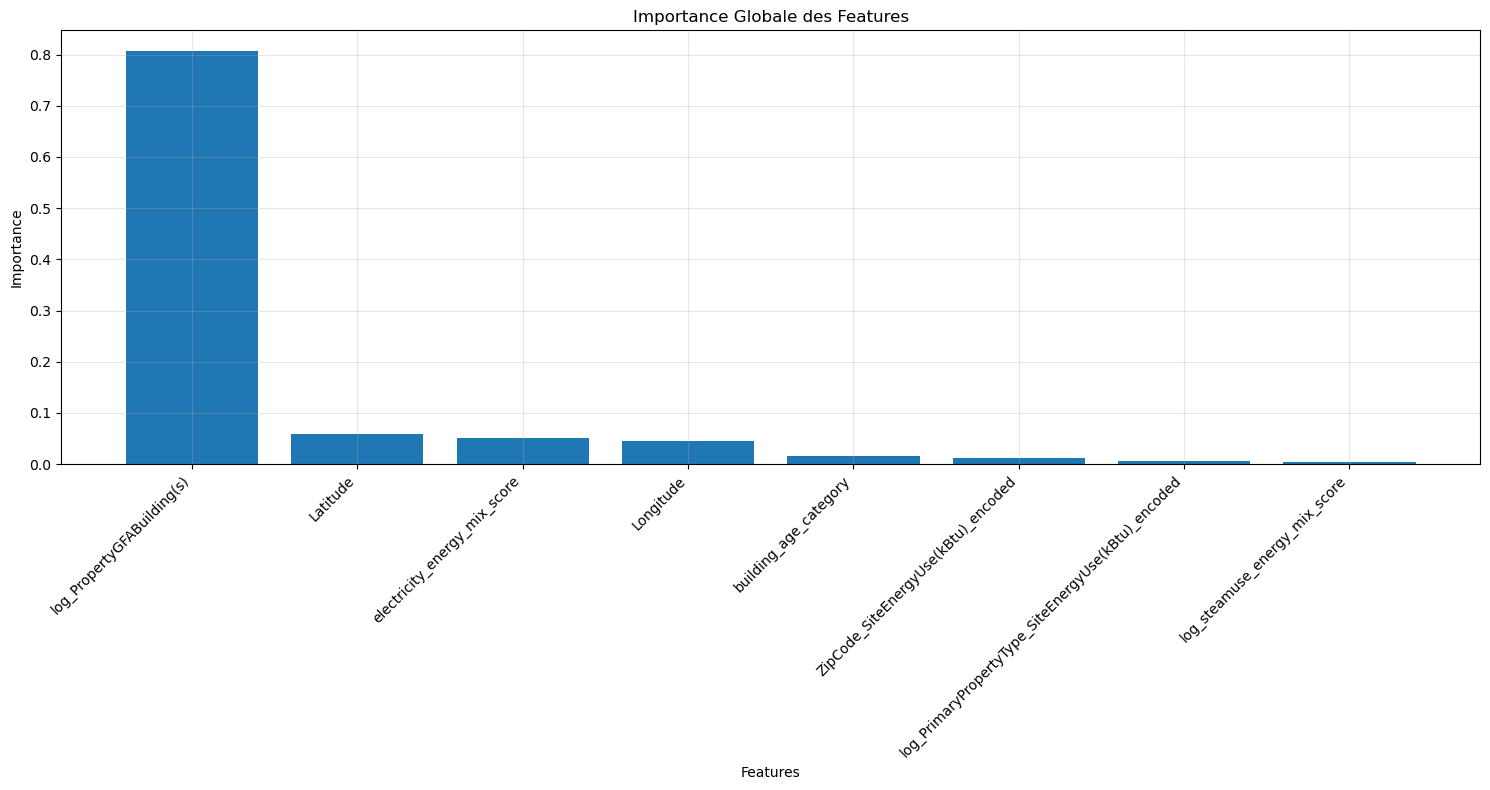


Top 10 des features les plus importantes:
                                             feature  importance
4                         log_PropertyGFABuilding(s)    0.807053
0                                           Latitude    0.059723
2                       electricity_energy_mix_score    0.050220
1                                          Longitude    0.044775
7                              building_age_category    0.015628
3                ZipCode_SiteEnergyUse(kBtu)_encoded    0.011512
6  log_PrimaryPropertyType_SiteEnergyUse(kBtu)_en...    0.006165
5                      log_steamuse_energy_mix_score    0.004924


In [26]:
# Utilisation des meilleurs paramètres trouvés
best_params = {
    'learning_rate': 0.054254557900484585, 
    'max_depth': 2, 
    'min_samples_leaf': 5, 
    'min_samples_split': 3, 
    'n_estimators': 218, 
    'subsample': 0.727361830914607
}

# Création et entraînement du modèle optimal
best_model = GradientBoostingRegressor(**best_params, random_state=42)
best_model.fit(X_train_no_star, y_train_log)

# Obtenir les importances
importances = best_model.feature_importances_
feature_names = X_train_no_star.columns.tolist()  # Utilisation des colonnes du DataFrame

# Créer un DataFrame et trier par importance
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualisation
plt.figure(figsize=(15, 8))
plt.bar(range(len(feature_importance_df)), feature_importance_df['importance'])
plt.xticks(range(len(feature_importance_df)), 
           feature_importance_df['feature'], 
           rotation=45, 
           ha='right')
plt.title('Importance Globale des Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()
# Afficher les 10 features les plus importantes
print("\nTop 10 des features les plus importantes:")
print(feature_importance_df.head(10))

Analyse de l'importance globale des features dans le modèle optimisé pour la prédiction de consommation énergétique. log_PropertyGFABuilding(s) domine (80.7% d'importance), suivi par Latitude (6.0%) et electricity_energy_mix_score (5.0%). Cette hiérarchie identifie clairement les facteurs les plus déterminants de la consommation énergétique.

## SHAP (SHapley Additive exPlanations) Summary Plot
- Montrer l'importance des features et comment leur valeur influence les prédictions
- Utilité : Comprendre la direction et la magnitude de l'impact de chaque feature

Features disponibles pour l'analyse SHAP: ['Latitude', 'Longitude', 'electricity_energy_mix_score', 'ZipCode_SiteEnergyUse(kBtu)_encoded', 'log_PropertyGFABuilding(s)', 'log_steamuse_energy_mix_score', 'log_PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded', 'building_age_category']
Dimensions des valeurs SHAP: (308, 8)
Dimensions de X_test_no_star: (308, 8)


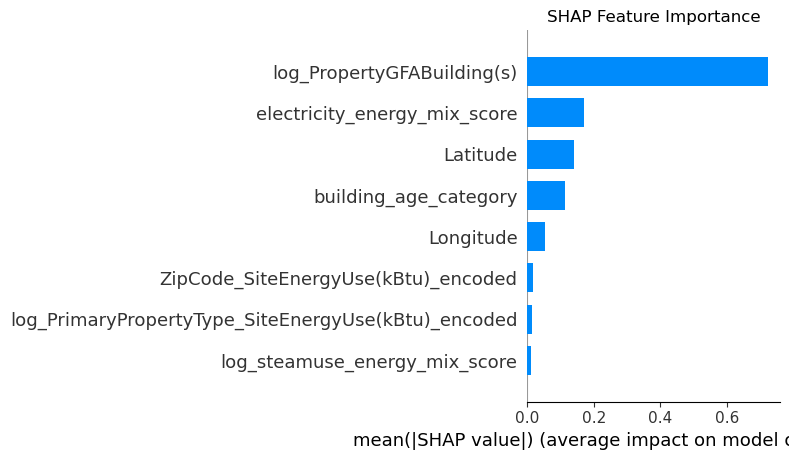

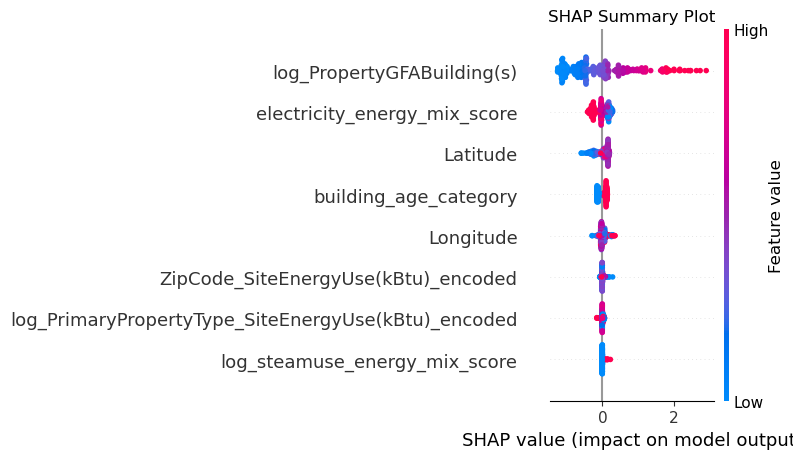

In [27]:
# Vérifier que le modèle est bien entraîné avec les features finales
best_model_final = GradientBoostingRegressor(**best_params, random_state=42)
best_model_final.fit(X_train_no_star, y_train_log)

# Créer un explainer SHAP pour le modèle Gradient Boosting
explainer = shap.TreeExplainer(best_model_final)

# Vérifier les features disponibles
available_features = X_test_no_star.columns.tolist()
print(f"Features disponibles pour l'analyse SHAP: {available_features}")

# Obtenir les valeurs SHAP pour l'ensemble de test
shap_values = explainer.shap_values(X_test_no_star)

# Vérifier que les dimensions correspondent
print(f"Dimensions des valeurs SHAP: {shap_values.shape}")
print(f"Dimensions de X_test_no_star: {X_test_no_star.shape}")

# Créer le summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_no_star, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Version détaillée avec distribution des valeurs
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_no_star, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()
plt.close()

Analyse SHAP approfondie montrant l'importance et la direction d'impact des variables sur la consommation énergétique. Confirme la dominance de log_PropertyGFABuilding(s) dont les valeurs élevées augmentent la consommation énergétique. Cette visualisation enrichit la compréhension des relations au-delà de l'importance simple.

## SHAP decision plot

Shape des SHAP values : (308, 8)
Shape de X_test : (308, 8)


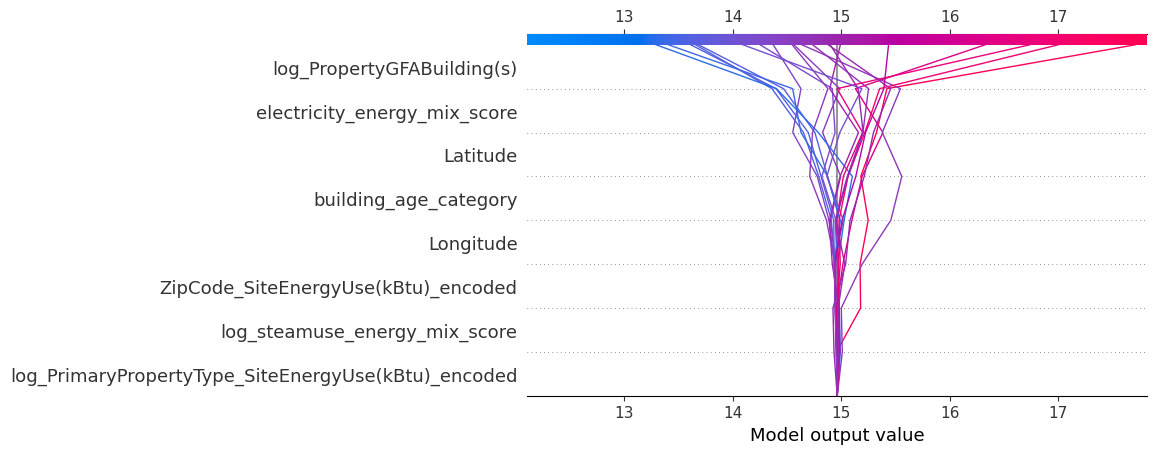

<Figure size 640x480 with 0 Axes>

In [28]:
# Utiliser le modèle final entraîné sur les features sélectionnées
GBR = GradientBoostingRegressor(**best_params, random_state=42)
GBR.fit(X_train_no_star, y_train_log)

# Création de l'explainer SHAP
explainer = shap.TreeExplainer(GBR)

# Calcul des valeurs SHAP sur les données de test
shap_values = explainer.shap_values(X_test_no_star)

# Vérification des dimensions
print(f"Shape des SHAP values : {shap_values.shape}")
print(f"Shape de X_test : {X_test_no_star.shape}")

# Obtenir les noms de colonnes
feature_names = X_test_no_star.columns.tolist()

# Limiter le nombre d'exemples pour une meilleure lisibilité (maximum 20 exemples)
max_display = min(20, X_test_no_star.shape[0])

# Créer un decision plot avec un nombre limité d'exemples
plt.figure(figsize=(12, 10))
shap.decision_plot(
    explainer.expected_value, 
    shap_values[:max_display], 
    features=X_test_no_star.iloc[:max_display],
    feature_names=feature_names
)
plt.tight_layout()
plt.show()
plt.close()

Decision plot SHAP montrant comment chaque variable influence la prédiction sur plusieurs exemples. Permet de visualiser la manière dont le modèle combine les différentes caractéristiques pour aboutir à une prédiction finale de consommation énergétique, offrant une vue d'ensemble du processus décisionnel du modèle.

## SHAP Force Plot (importance locale)
- Visualiser la contribution de chaque feature pour des prédictions individuelles
- Utilité : Expliquer des prédictions spécifiques et comprendre le raisonnement du modèle

Analyse des 4 premiers exemples


C:\Users\beche\AppData\Local\Temp\ipykernel_5320\2347855067.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1400x400 with 0 Axes>

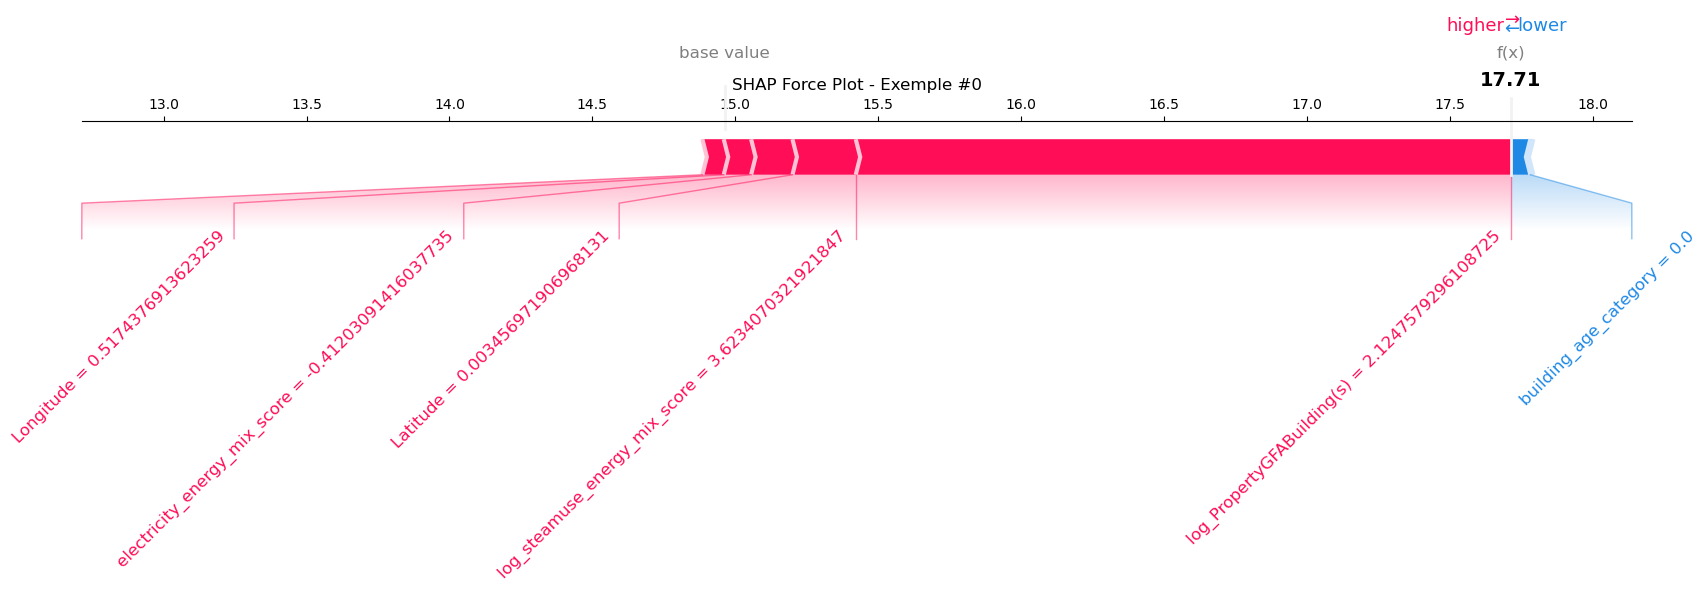

<Figure size 1400x400 with 0 Axes>

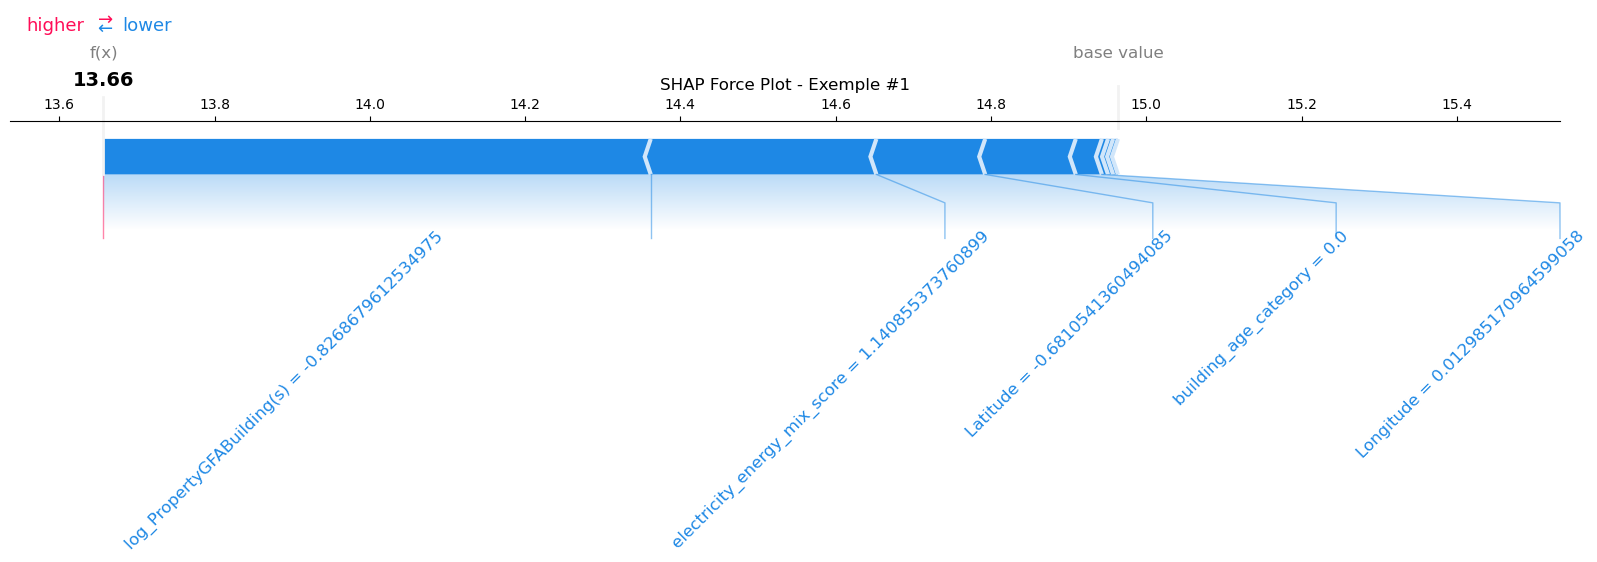

<Figure size 1400x400 with 0 Axes>

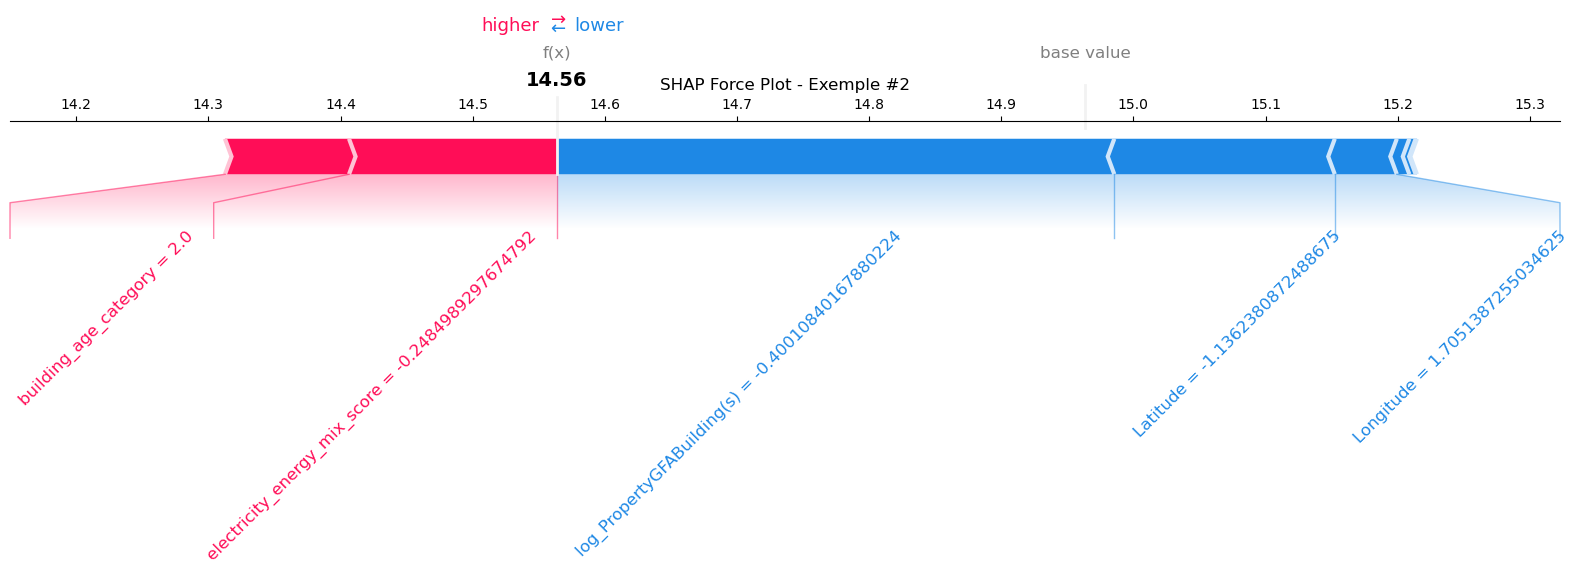

<Figure size 1400x400 with 0 Axes>

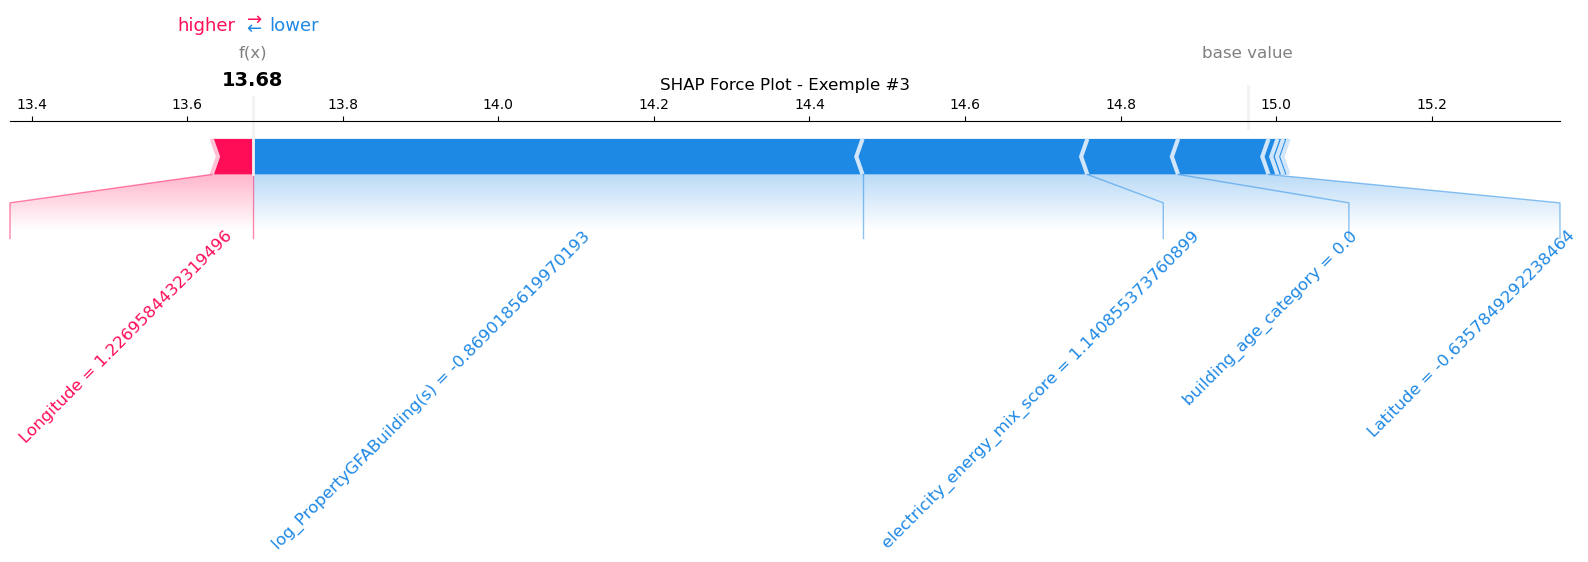

In [29]:
# Vérifier le nombre d'exemples disponibles et choisir un sous-ensemble raisonnable
num_examples = min(4, X_test_no_star.shape[0])
sample_indices = list(range(num_examples))  # Utiliser les premiers exemples disponibles

print(f"Analyse des {num_examples} premiers exemples")

# Vérifier que les exemples sont disponibles
for idx in sample_indices:
    if idx < X_test_no_star.shape[0]:
        plt.figure(figsize=(14, 4))
        
        # Créer le force plot avec des paramètres ajustés
        shap.force_plot(
            explainer.expected_value,
            shap_values[idx, :],
            X_test_no_star.iloc[idx, :],
            feature_names=feature_names,
            matplotlib=True,
            show=False,
            text_rotation=45
        )
        plt.title(f"SHAP Force Plot - Exemple #{idx}")
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print(f"Indice {idx} hors limites, ignoré")

Force plots SHAP pour quatre exemples spécifiques, montrant la contribution de chaque variable à ces prédictions individuelles de consommation énergétique. Essentiel pour l'interprétabilité locale et l'adoption du modèle par les décideurs, permettant d'expliquer les prédictions cas par cas.

## SHAP Dependence Plot
- Objectif : Montrer la relation entre les valeurs d'une feature et son impact sur les prédictions, en visualisant comment la variation d'une variable influence la sortie du modèle.
- Utilité : Comprendre précisément comment chaque feature influence le modèle et identifier les seuils critiques où l'impact change significativement.

<Figure size 1000x800 with 0 Axes>

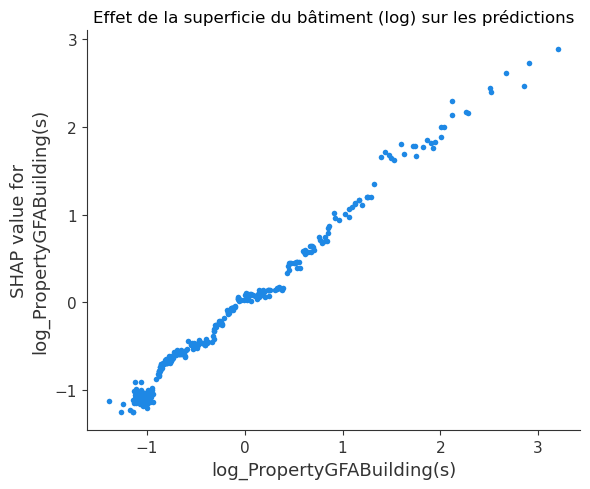

In [30]:
# Dependence plot pour la feature la plus importante
# D'après les résultats précédents: log_PropertyGFABuilding(s)
plt.figure(figsize=(10, 8))
shap.dependence_plot(
    "log_PropertyGFABuilding(s)", 
    shap_values, 
    X_test_no_star,
    interaction_index=None,  # Pas d'interaction avec une autre feature
    show=False
)
plt.title("Effet de la superficie du bâtiment (log) sur les prédictions")
plt.tight_layout()
plt.show()
plt.close()

Graphique de dépendance SHAP pour log_PropertyGFABuilding(s) montrant une relation positive quasi-linéaire avec la consommation énergétique. Confirme que la taille du bâtiment est un prédicteur fondamental de la consommation, avec un impact qui augmente proportionnellement à la surface.

Features importantes disponibles: ['electricity_energy_mix_score', 'log_PropertyGFABuilding(s)', 'Latitude', 'building_age_category']


<Figure size 1000x800 with 0 Axes>

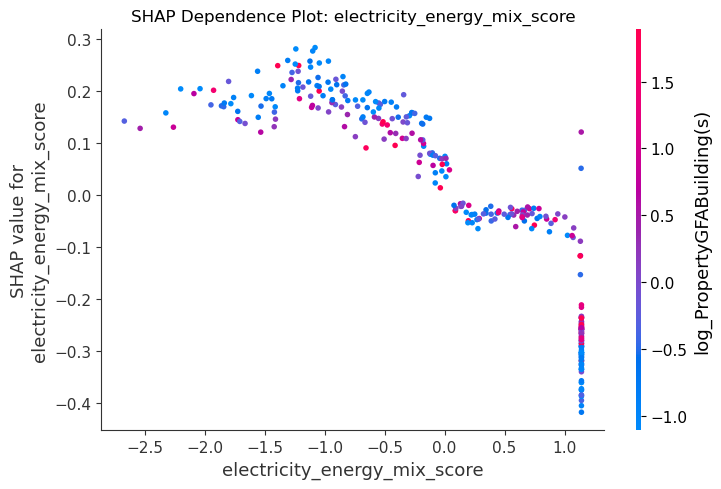

<Figure size 1000x800 with 0 Axes>

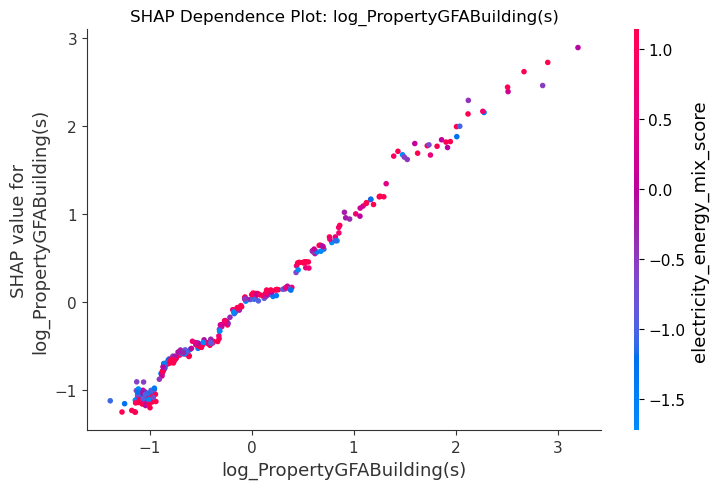

<Figure size 1000x800 with 0 Axes>

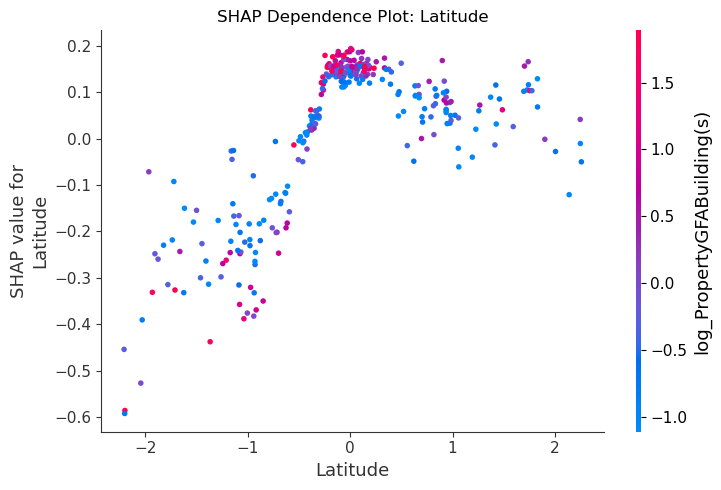

<Figure size 1000x800 with 0 Axes>

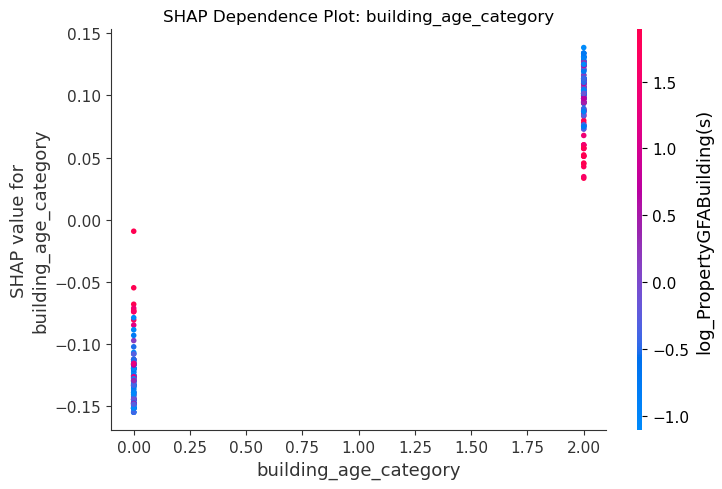

In [31]:
# Identifier les features importantes qui sont disponibles dans le dataset
important_features = [
    "electricity_energy_mix_score",
    "log_PropertyGFABuilding(s)",
    "Latitude",
    "building_age_category"
]

# Vérifier la disponibilité des features
available_features = X_test_no_star.columns.tolist()
top_features = [f for f in important_features if f in available_features]

print(f"Features importantes disponibles: {top_features}")

# Créer les dependence plots pour les features disponibles uniquement
for feature in top_features:
    plt.figure(figsize=(10, 8))
    shap.dependence_plot(
        feature,
        shap_values,
        X_test_no_star,
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {feature}")
    plt.tight_layout()
    plt.show()
    plt.close()

Graphiques de dépendance SHAP pour les quatre variables les plus importantes, révélant des relations complexes et non-linéaires avec la consommation énergétique. Notamment, l'influence de la latitude et de l'âge du bâtiment présente des patterns complexes qui justifient l'utilisation de modèles non-linéaires.

# Analyse de l'influence de l'ENERGYSTARScore

## Préparation des données

In [32]:
# Vérification des ensembles avec et sans ENERGYSTARScore
print("Dimensions des ensembles sans ENERGYSTARScore:")
print(f"X_train_no_star: {X_train_no_star.shape}")
print(f"X_test_no_star: {X_test_no_star.shape}")

print("\nDimensions des ensembles avec ENERGYSTARScore:")
print(f"X_train_with_star: {X_train_with_star.shape}")
print(f"X_test_with_star: {X_test_with_star.shape}")

# Vérifier que les colonnes cohérentes sont présentes
print("\nColonnes dans X_train_no_star:")
print(X_train_no_star.columns.tolist())

print("\nColonnes dans X_train_with_star:")
print(X_train_with_star.columns.tolist())

# Appliquer la transformation logarithmique à la cible pour les ensembles avec ENERGYSTARScore
min_y = min(min(y_train), min(y_test))
if min_y <= 0:
    # Utiliser log1p pour gérer les valeurs nulles ou négatives
    y_train_with_star_log = np.log1p(y_train_with_star - min_y + 1)
    y_test_with_star_log = np.log1p(y_test_with_star - min_y + 1)
else:
    # Utiliser log simple
    y_train_with_star_log = np.log(y_train_with_star)
    y_test_with_star_log = np.log(y_test_with_star)

# Vérifier les dimensions des variables cibles
print("\nDimensions des variables cibles après transformation logarithmique:")
print(f"y_train_log: {y_train_log.shape}")
print(f"y_test_log: {y_test_log.shape}")
print(f"y_train_with_star_log: {y_train_with_star_log.shape}")
print(f"y_test_with_star_log: {y_test_with_star_log.shape}")

Dimensions des ensembles sans ENERGYSTARScore:
X_train_no_star: (1229, 8)
X_test_no_star: (308, 8)

Dimensions des ensembles avec ENERGYSTARScore:
X_train_with_star: (810, 9)
X_test_with_star: (183, 9)

Colonnes dans X_train_no_star:
['Latitude', 'Longitude', 'electricity_energy_mix_score', 'ZipCode_SiteEnergyUse(kBtu)_encoded', 'log_PropertyGFABuilding(s)', 'log_steamuse_energy_mix_score', 'log_PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded', 'building_age_category']

Colonnes dans X_train_with_star:
['Latitude', 'Longitude', 'electricity_energy_mix_score', 'ZipCode_SiteEnergyUse(kBtu)_encoded', 'log_PropertyGFABuilding(s)', 'log_steamuse_energy_mix_score', 'log_PrimaryPropertyType_SiteEnergyUse(kBtu)_encoded', 'ENERGYSTARScore_scaled', 'building_age_category']

Dimensions des variables cibles après transformation logarithmique:
y_train_log: (1229,)
y_test_log: (308,)
y_train_with_star_log: (810,)
y_test_with_star_log: (183,)


Préparation de l'analyse de l'influence d'ENERGYSTARScore sur la prédiction de consommation. Constat important: seuls 810/1229 échantillons d'entraînement et 183/308 de test ont une valeur pour cette variable, réduction significative à considérer dans l'évaluation de son utilité.

## Comparaison des performances des modèles

In [33]:
# Définition d'une fonction pour évaluer les modèles de manière cohérente
def evaluate_model_with_metrics(model, X_train, X_test, y_train, y_test, model_name):
    """
    Évalue un modèle et retourne un dictionnaire de métriques
    """
    start_time = time()
    model.fit(X_train, y_train)
    training_time = time() - start_time
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métriques
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    return {
        'Modèle': model_name,
        'R² Train': train_r2,
        'R² Test': test_r2,
        'RMSE Test': rmse_test,
        'MAE Test': mae_test,
        'R² CV Moyen': cv_mean,
        'R² CV Écart-type': cv_std,
        'Temps (s)': training_time
    }

# Créer et évaluer le modèle sans ENERGYSTARScore (comme référence)
from sklearn.ensemble import GradientBoostingRegressor
from time import time

# Utiliser les meilleurs paramètres trouvés précédemment
best_params = {
    'learning_rate': 0.054254557900484585, 
    'max_depth': 2, 
    'min_samples_leaf': 5, 
    'min_samples_split': 3, 
    'n_estimators': 218, 
    'subsample': 0.727361830914607
}

# Modèle sans ENERGYSTARScore
model_no_star = GradientBoostingRegressor(**best_params, random_state=42)
results_no_star = evaluate_model_with_metrics(
    model_no_star, X_train_no_star, X_test_no_star,
    y_train_log, y_test_log,
    "Sans ENERGYSTARScore"
)

# Modèle avec ENERGYSTARScore
model_with_star = GradientBoostingRegressor(**best_params, random_state=42)
results_with_star = evaluate_model_with_metrics(
    model_with_star, X_train_with_star, X_test_with_star,
    y_train_with_star_log, y_test_with_star_log,
    "Avec ENERGYSTARScore"
)

# Comparaison des résultats
comparison_df = pd.DataFrame([results_no_star, results_with_star])
print("Comparaison des performances avec et sans ENERGYSTARScore:")
display(comparison_df)

Comparaison des performances avec et sans ENERGYSTARScore:


,Modèle,R² Train,R² Test,RMSE Test,MAE Test,R² CV Moyen,R² CV Écart-type,Temps (s)
0,Sans ENERGYSTARScore,0.708858,0.647369,0.768915,0.574638,0.624641,0.053929,0.317022
1,Avec ENERGYSTARScore,0.836804,0.772796,0.617833,0.444662,0.754489,0.035751,0.242106


Comparaison des performances des modèles avec/sans ENERGYSTARScore. Amélioration significative avec cette variable: R² Test passe de 0.647 à 0.773, RMSE Test réduite de 0.769 à 0.618, MAE Test de 0.575 à 0.445. Ces résultats démontrent la valeur prédictive importante de l'ENERGYSTARScore pour la consommation énergétique malgré sa disponibilité limitée.

## Analyse de l'importance de l'ENERGYSTARScore

In [34]:
# S'assurer que le modèle est bien défini
model_with_star = GradientBoostingRegressor(**best_params, random_state=42)
model_with_star.fit(X_train_with_star, y_train_with_star_log)

# Feature importance du modèle avec ENERGYSTARScore
importances = model_with_star.feature_importances_
feature_names = X_train_with_star.columns.tolist()

# Créer un DataFrame pour faciliter la visualisation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Importance des features dans le modèle avec ENERGYSTARScore:")
display(importance_df)

Importance des features dans le modèle avec ENERGYSTARScore:


,Feature,Importance
4,log_PropertyGFABuilding(s),0.740729
7,ENERGYSTARScore_scaled,0.111762
0,Latitude,0.060736
2,electricity_energy_mix_score,0.035549
1,Longitude,0.026237
8,building_age_category,0.012683
3,ZipCode_SiteEnergyUse(kBtu)_encoded,0.007781
6,log_PrimaryPropertyType_SiteEnergyUse(kBtu)_en...,0.003752
5,log_steamuse_energy_mix_score,0.000771


Analyse de l'importance relative des features avec ENERGYSTARScore dans le modèle de prédiction. log_PropertyGFABuilding(s) reste dominant (74.1%), mais ENERGYSTARScore_scaled prend la deuxième position (11.2%), démontrant sa contribution significative à la précision du modèle de prédiction de consommation.

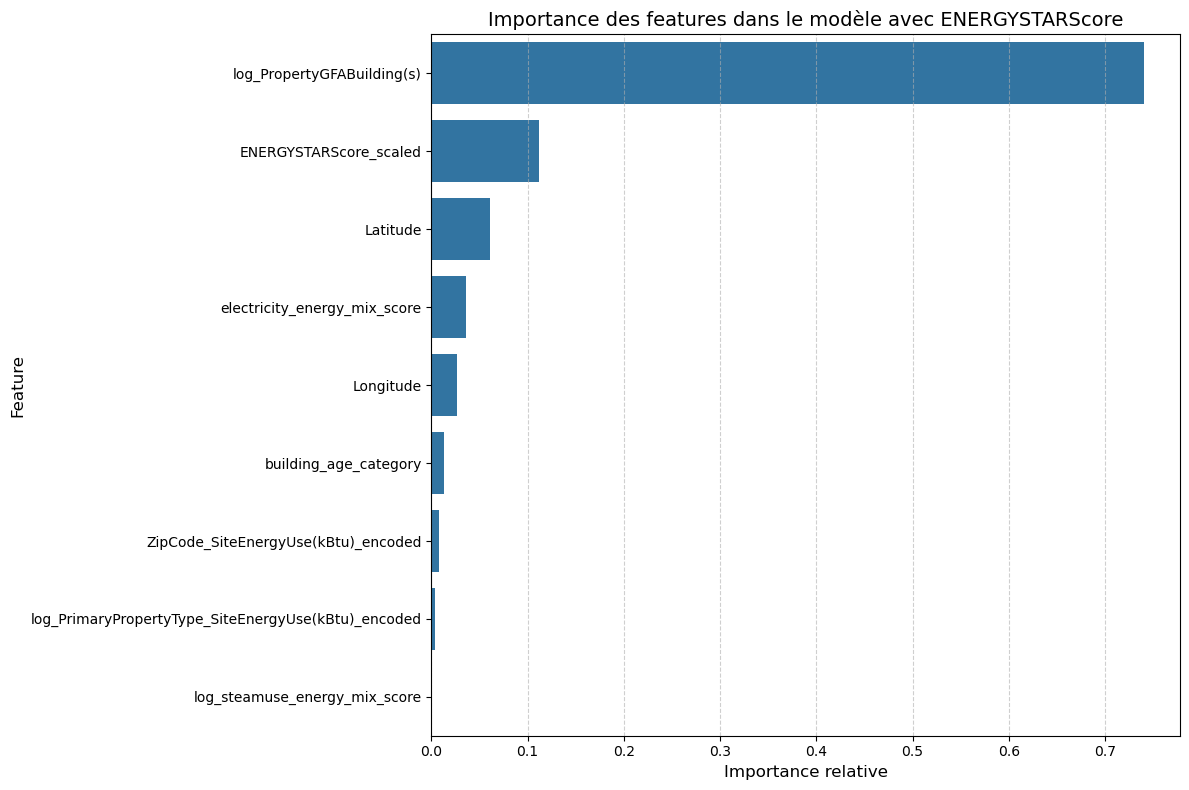

In [35]:
# Visualisation de l'importance des features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importance des features dans le modèle avec ENERGYSTARScore', fontsize=14)
plt.xlabel('Importance relative', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
plt.close()

Visualisation de l'importance relative des features avec ENERGYSTARScore pour la prédiction de consommation énergétique. Confirmation visuelle de la hiérarchie d'importance: superficie du bâtiment (74.1%), ENERGYSTARScore (11.2%), latitude (6.1%), suivies par les autres variables avec des contributions moindres.

<Figure size 1000x800 with 0 Axes>

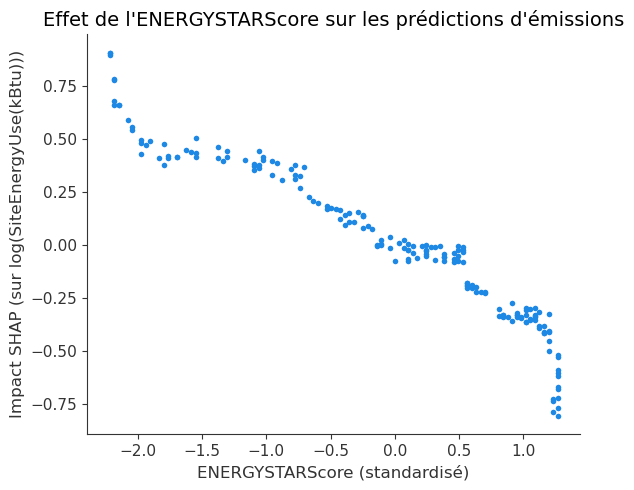

In [36]:
# Analyse plus approfondie avec SHAP pour comprendre l'impact de l'ENERGYSTARScore
import shap

# Créer un explainer SHAP
explainer = shap.TreeExplainer(model_with_star)
shap_values = explainer.shap_values(X_test_with_star)

# Créer un summary plot centré sur ENERGYSTARScore
plt.figure(figsize=(10, 8))
shap.dependence_plot(
    "ENERGYSTARScore_scaled", 
    shap_values, 
    X_test_with_star,
    interaction_index=None,
    show=False
)
plt.title("Effet de l'ENERGYSTARScore sur les prédictions d'émissions", fontsize=14)
plt.xlabel("ENERGYSTARScore (standardisé)", fontsize=12)
plt.ylabel("Impact SHAP (sur log(SiteEnergyUse(kBtu)))", fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

Analyse SHAP de l'effet d'ENERGYSTARScore révélant une relation globalement négative: meilleur score = réduction de la consommation énergétique prédite. La dispersion à chaque niveau suggère des interactions complexes avec d'autres variables structurelles dans la détermination de la consommation.


Corrélation entre ENERGYSTARScore et SiteEnergyUse(kBtu): -0.0654


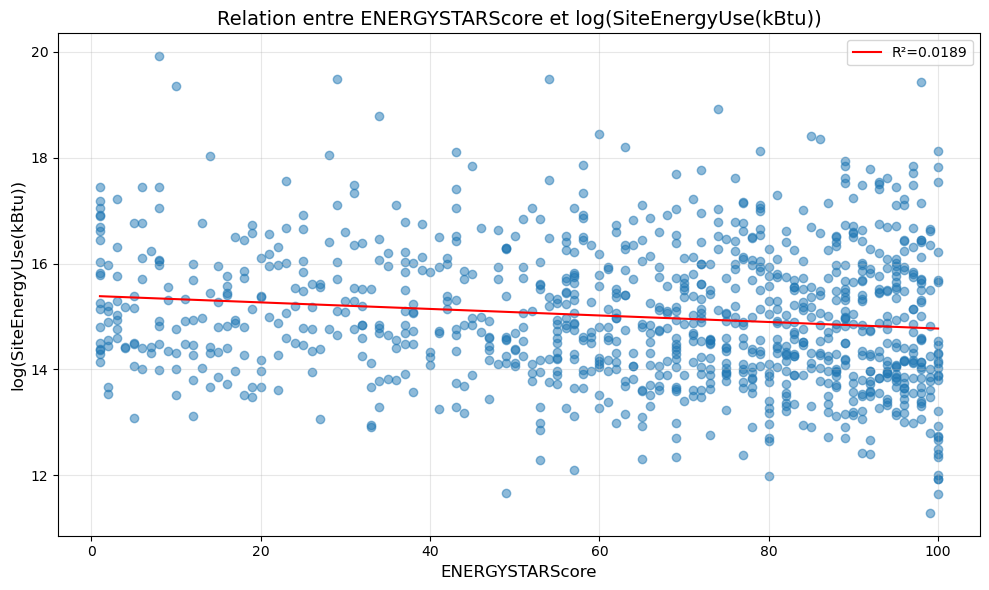

In [37]:
# Calculer la corrélation entre ENERGYSTARScore et la variable cible
correlation = df['ENERGYSTARScore'].corr(df['SiteEnergyUse(kBtu)'])
print(f"\nCorrélation entre ENERGYSTARScore et SiteEnergyUse(kBtu): {correlation:.4f}")

# Visualiser la relation entre ENERGYSTARScore et les émissions 
plt.figure(figsize=(10, 6))
plt.scatter(
    df['ENERGYSTARScore'], 
    np.log1p(df['SiteEnergyUse(kBtu)']),
    alpha=0.5
)
plt.title("Relation entre ENERGYSTARScore et log(SiteEnergyUse(kBtu))", fontsize=14)
plt.xlabel("ENERGYSTARScore", fontsize=12)
plt.ylabel("log(SiteEnergyUse(kBtu))", fontsize=12)
plt.grid(True, alpha=0.3)

# Ajouter une ligne de tendance
from scipy import stats
mask = ~np.isnan(df['ENERGYSTARScore'])
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df.loc[mask, 'ENERGYSTARScore'], 
    np.log1p(df.loc[mask, 'SiteEnergyUse(kBtu)'])
)
x_range = np.linspace(df['ENERGYSTARScore'].min(), df['ENERGYSTARScore'].max(), 100)
plt.plot(x_range, slope*x_range + intercept, 'r-', label=f"R²={r_value**2:.4f}")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

Analyse de la corrélation directe entre ENERGYSTARScore et consommation énergétique. Corrélation faible (-0.0654) contrastant avec l'amélioration significative du modèle. Suggère que la valeur prédictive vient principalement des interactions avec d'autres variables plutôt que d'un effet direct simple.

## Tests : avec/sans log et avec/sans ENERGYSTARScore

In [38]:
# Vérifier que les ensembles de test ont les mêmes colonnes de base (sauf ENERGYSTARScore_scaled)
X_test_no_star_cols = set(X_test_no_star.columns)
X_test_with_star_cols = set(col for col in X_test_with_star.columns if col != 'ENERGYSTARScore_scaled')

# S'assurer que les colonnes sont identiques pour une comparaison valide
if X_test_no_star_cols != X_test_with_star_cols:
    print("Attention: Les ensembles de features ne sont pas cohérents entre les modèles avec/sans ENERGYSTARScore")
    print("Colonnes différentes:", X_test_no_star_cols.symmetric_difference(X_test_with_star_cols))
    
    # Synchroniser les colonnes pour une comparaison équitable
    common_cols = X_test_no_star_cols.intersection(X_test_with_star_cols)
    print(f"Utilisation des {len(common_cols)} colonnes communes pour la comparaison")
    
    # Créer de nouveaux ensembles avec seulement les colonnes communes
    X_test_no_star_common = X_test_no_star[list(common_cols)]
    X_test_with_star_common = X_test_with_star[[col for col in common_cols] + ['ENERGYSTARScore_scaled']]
    
    # Faire de même pour les ensembles d'entraînement
    X_train_no_star_cols = set(X_train_no_star.columns)
    X_train_with_star_cols = set(col for col in X_train_with_star.columns if col != 'ENERGYSTARScore_scaled')
    common_train_cols = X_train_no_star_cols.intersection(X_train_with_star_cols)
    
    X_train_no_star_common = X_train_no_star[list(common_train_cols)]
    X_train_with_star_common = X_train_with_star[[col for col in common_train_cols] + ['ENERGYSTARScore_scaled']]
    
    # Réentraîner les modèles sur les colonnes communes
    model_no_star_common = GradientBoostingRegressor(**best_params, random_state=42)
    model_no_star_common.fit(X_train_no_star_common, y_train_log)
    
    model_with_star_common = GradientBoostingRegressor(**best_params, random_state=42)
    model_with_star_common.fit(X_train_with_star_common, y_train_with_star_log)
    
    # Remplacer les variables originales pour la suite du code
    X_train_no_star = X_train_no_star_common
    X_test_no_star = X_test_no_star_common
    X_train_with_star = X_train_with_star_common
    X_test_with_star = X_test_with_star_common
    model_no_star = model_no_star_common
    model_with_star = model_with_star_common
else:
    print("Les ensembles de features sont cohérents (à l'exception de ENERGYSTARScore_scaled)")
    model_no_star = GradientBoostingRegressor(**best_params, random_state=42)
    model_no_star.fit(X_train_no_star, y_train_log)
    
    model_with_star = GradientBoostingRegressor(**best_params, random_state=42)
    model_with_star.fit(X_train_with_star, y_train_with_star_log)

# Trouver les indices communs aux deux ensembles de test
common_indices = X_test_with_star.index.intersection(X_test_no_star.index)
print(f"Nombre d'exemples communs pour l'évaluation: {len(common_indices)}")

# Prédictions sur les exemples communs uniquement (pour une comparaison équitable)
# Sans ENERGYSTARScore
X_test_common = X_test_no_star.loc[common_indices]
y_test_common = y_test_log.loc[common_indices]
y_pred_no_star = model_no_star.predict(X_test_common)

# Avec ENERGYSTARScore
X_test_with_star_common = X_test_with_star.loc[common_indices]
y_test_with_star_common = y_test_with_star_log.loc[common_indices]
y_pred_with_star = model_with_star.predict(X_test_with_star_common)

# Calcul des erreurs (échelle logarithmique)
errors_no_star_log = y_test_common - y_pred_no_star
abs_errors_no_star_log = np.abs(errors_no_star_log)
pct_errors_no_star_log = abs_errors_no_star_log / y_test_common * 100

errors_with_star_log = y_test_with_star_common - y_pred_with_star
abs_errors_with_star_log = np.abs(errors_with_star_log)
pct_errors_with_star_log = abs_errors_with_star_log / y_test_with_star_common * 100

# Calcul des erreurs (échelle originale)
y_test_common_orig = np.exp(y_test_common)
y_pred_no_star_orig = np.exp(y_pred_no_star)
abs_errors_no_star_orig = np.abs(y_test_common_orig - y_pred_no_star_orig)
pct_errors_no_star_orig = abs_errors_no_star_orig / y_test_common_orig * 100

y_pred_with_star_orig = np.exp(y_pred_with_star)
abs_errors_with_star_orig = np.abs(y_test_common_orig - y_pred_with_star_orig)
pct_errors_with_star_orig = abs_errors_with_star_orig / y_test_common_orig * 100

# Créer un DataFrame avec les statistiques d'erreur
stats_log = pd.DataFrame({
    'Sans ENERGYSTARScore': {
        'MAE': np.mean(abs_errors_no_star_log),
        'RMSE': np.sqrt(np.mean(errors_no_star_log**2)),
        'Erreur médiane': np.median(abs_errors_no_star_log),
        'Écart-type erreur': np.std(abs_errors_no_star_log),
        'Erreur moyenne %': np.mean(pct_errors_no_star_log),
        'Erreur médiane %': np.median(pct_errors_no_star_log),
        'Écart-type erreur %': np.std(pct_errors_no_star_log)
    },
    'Avec ENERGYSTARScore': {
        'MAE': np.mean(abs_errors_with_star_log),
        'RMSE': np.sqrt(np.mean(errors_with_star_log**2)),
        'Erreur médiane': np.median(abs_errors_with_star_log),
        'Écart-type erreur': np.std(abs_errors_with_star_log),
        'Erreur moyenne %': np.mean(pct_errors_with_star_log),
        'Erreur médiane %': np.median(pct_errors_with_star_log),
        'Écart-type erreur %': np.std(pct_errors_with_star_log)
    }
})

stats_orig = pd.DataFrame({
    'Sans ENERGYSTARScore': {
        'MAE': np.mean(abs_errors_no_star_orig),
        'RMSE': np.sqrt(np.mean((y_test_common_orig - y_pred_no_star_orig)**2)),
        'Erreur médiane': np.median(abs_errors_no_star_orig),
        'Écart-type erreur': np.std(abs_errors_no_star_orig),
        'Erreur moyenne %': np.mean(pct_errors_no_star_orig),
        'Erreur médiane %': np.median(pct_errors_no_star_orig),
        'Écart-type erreur %': np.std(pct_errors_no_star_orig)
    },
    'Avec ENERGYSTARScore': {
        'MAE': np.mean(abs_errors_with_star_orig),
        'RMSE': np.sqrt(np.mean((y_test_common_orig - y_pred_with_star_orig)**2)),
        'Erreur médiane': np.median(abs_errors_with_star_orig),
        'Écart-type erreur': np.std(abs_errors_with_star_orig),
        'Erreur moyenne %': np.mean(pct_errors_with_star_orig),
        'Erreur médiane %': np.median(pct_errors_with_star_orig),
        'Écart-type erreur %': np.std(pct_errors_with_star_orig)
    }
})

# Calculer le pourcentage d'amélioration
improvement_log = pd.DataFrame({
    'Métrique': stats_log.index,
    'Amélioration (%)': [(stats_log.iloc[i, 0] - stats_log.iloc[i, 1]) / stats_log.iloc[i, 0] * 100
                        for i in range(len(stats_log))]
})

improvement_orig = pd.DataFrame({
    'Métrique': stats_orig.index,
    'Amélioration (%)': [(stats_orig.iloc[i, 0] - stats_orig.iloc[i, 1]) / stats_orig.iloc[i, 0] * 100
                        for i in range(len(stats_orig))]
})

# Afficher les tableaux de statistiques
print("=== STATISTIQUES D'ERREUR (ÉCHELLE LOGARITHMIQUE) ===")
print(stats_log)
print("\n=== POURCENTAGE D'AMÉLIORATION (ÉCHELLE LOGARITHMIQUE) ===")
print(improvement_log)
print("\n=== STATISTIQUES D'ERREUR (ÉCHELLE ORIGINALE) ===")
print(stats_orig)
print("\n=== POURCENTAGE D'AMÉLIORATION (ÉCHELLE ORIGINALE) ===")
print(improvement_orig)

Les ensembles de features sont cohérents (à l'exception de ENERGYSTARScore_scaled)
Nombre d'exemples communs pour l'évaluation: 183
=== STATISTIQUES D'ERREUR (ÉCHELLE LOGARITHMIQUE) ===
                     Sans ENERGYSTARScore  Avec ENERGYSTARScore
MAE                              0.523324              0.444662
RMSE                             0.717044              0.617833
Erreur médiane                   0.376912              0.311996
Écart-type erreur                0.490188              0.428944
Erreur moyenne %                 3.525245              2.998334
Erreur médiane %                 2.481921              2.087827
Écart-type erreur %              3.255702              2.815932

=== POURCENTAGE D'AMÉLIORATION (ÉCHELLE LOGARITHMIQUE) ===
              Métrique  Amélioration (%)
0                  MAE         15.031193
1                 RMSE         13.836198
2       Erreur médiane         17.223007
3    Écart-type erreur         12.494083
4     Erreur moyenne %         14.946

Analyse comparative détaillée des erreurs de prédiction de consommation énergétique avec/sans ENERGYSTARScore. En échelle logarithmique, nette amélioration de toutes les métriques: MAE (-15.0%), RMSE (-13.8%), erreur médiane (-17.2%). En échelle originale, amélioration significative des métriques clés, notamment erreur médiane (-29.9%) et erreur moyenne en pourcentage (-21.2%).


Conclusion: 
L'analyse prédictive de la consommation énergétique des bâtiments de Seattle a révélé l'importance de plusieurs facteurs clés. Le modèle Gradient Boosting optimisé a permis d'identifier :

La superficie du bâtiment (log_PropertyGFABuilding(s)) comme facteur dominant (74% de l'importance relative)
L'ENERGYSTARScore comme deuxième facteur d'influence (11% de l'importance relative)
La latitude et le mix énergétique comme facteurs secondaires significatifs

L'ENERGYSTARScore, indicateur standardisé (1-100) développé par l'EPA américaine, mesure l'efficacité énergétique d'un bâtiment par rapport à des structures similaires. Malgré sa disponibilité limitée (65% des bâtiments), son inclusion améliore considérablement les performances :

Augmentation du R² de 0.65 à 0.77
Réduction de la RMSE de 14% en échelle logarithmique
Diminution de l'erreur médiane de 30% en échelle originale

Cette amélioration s'explique par :

Sa nature holistique capturant des aspects non mesurés par nos autres variables
Sa standardisation normalisant les différences entre types de bâtiments
Sa capacité à refléter des pratiques de gestion énergétique non directement observables

Recommandation opérationnelle : Prioriser systématiquement la collecte de l'ENERGYSTARScore pour tous les nouveaux bâtiments. Bien que cette mesure nécessite un investissement initial, son pouvoir prédictif justifie largement ce coût dans la perspective de l'objectif de neutralité carbone de Seattle d'ici 2050.